# 1. Introduction

For this project, let's take a look at a data of a UK-based online retailer from 2010-2011 containing information related to the transactions made from 2010 to 2011.

This case study will focus on: exploring the data and extracting important insights
* Exploratory Data Analysis (EDA)
* RFM Analysis: find out the customers' RFM features (Recency, Frequency, Monetary)
* Customer classification based on their RFM information: K-Means Clustering and Hierarchical Clustering Model

This data consists of over 500,000 records of customer orders, including 8 variables that correspond to:

* InvoiceNo: Invoice number
* StockCode: Product code
* Description: Product name
* Quantity: The quantities of the product each transaction
* InvoiceDate: Invoice Date and time
* UnitPrice: Price per unit
* CustomerID: Customer number
* Country: The country where each customer resides

# 2. Understanding the Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy

In [2]:
data = pd.read_csv(r'data (raw).csv', encoding= 'unicode_escape')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


One takeway is that the date stops at early December 2011. This means either the store closed in the rest of the year, or the data insufficient for this month.

In [3]:
df = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In the column of product description, there seems to be various special cases: damaged, unsaleable, etc. These status will be checked later.

Apart from those special status, it is evident that one product code may have multiple names and vice versa. This can be explained by the fact that there are variations and groups of products that leads to multiple stock codes for a product name, or multiple names for a product.

# 3. Data Cleaning and Preparing

## 3.1. Invalid Data

In [5]:
# count cells in main data with 0 or negative in quantity or price
invalid_quant = (df['Quantity'] <= 0).sum()
invalid_price = (df['UnitPrice'] <= 0).sum()

print(f'Number of cells with invalid quantity: {invalid_quant}')
print(f'Number of cells with invalid price: {invalid_price}')

Number of cells with invalid quantity: 10624
Number of cells with invalid price: 2517


In [6]:
df[(df['Quantity'] <= 0) & (df['UnitPrice'] <= 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,12/1/2010 16:50,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,12/2/2010 14:42,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,12/3/2010 15:30,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,12/3/2010 15:30,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,12/3/2010 15:30,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,12/7/2011 18:36,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,12/7/2011 18:38,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,12/7/2011 18:38,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,12/8/2011 9:56,0.0,NaN,United Kingdom


Transactions with invalid quantity or price seems to include special status (description, e.g. missing). In this case study, we will not be digging into this subject, but rather the general insights regarding the performance of the store.

In [7]:
# Remove invalid rows
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530104 non-null  object 
 1   StockCode    530104 non-null  object 
 2   Description  530104 non-null  object 
 3   Quantity     530104 non-null  int64  
 4   InvoiceDate  530104 non-null  object 
 5   UnitPrice    530104 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      530104 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.4+ MB


In [8]:
# Count cells in main data containing "?", "-1", or nothing
count_qm = (df == '?').sum().sum()
count_neg_one = (df == -1).sum().sum()
count_empty = (df == '').sum().sum()

print(f"Number of cells containing '?': {count_qm}")
print(f"Number of cells containing '-1': {count_neg_one}")
print(f"Number of cells that does not contain anything: {count_empty}")

Number of cells containing '?': 0
Number of cells containing '-1': 0
Number of cells that does not contain anything: 0


Let's check the stock code for deeper understanding of the products.

In [9]:
# Check stock codes
for i in range(1,11):
    df_i = df[df['StockCode'].str.len() == i]
    num_code = len(df_i)
    print('----------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'\033[32mNumber of stock codes with {i} digit(s): {num_code}\033[0m')
    print('--------------------------------------------')
    print(df_i)

----------------------------------------------------------------------------------------------------------------------------------------------
Number of stock codes with 1 digit(s): 325
--------------------------------------------
       InvoiceNo StockCode Description  Quantity      InvoiceDate  UnitPrice  \
2239      536569         M      Manual         1  12/1/2010 15:35       1.25   
2250      536569         M      Manual         1  12/1/2010 15:35      18.95   
5684      536865         M      Manual         1  12/3/2010 11:28       2.55   
6798      536981         M      Manual         2  12/3/2010 14:26       0.85   
7976      537077         M      Manual        12  12/5/2010 11:59       0.42   
...          ...       ...         ...       ...              ...        ...   
526015    580645         M      Manual         1  12/5/2011 13:11     219.50   
526018    580646         M      Manual       800  12/5/2011 13:13       0.25   
530876    580884         M      Manual         1 

In [10]:
# Check stock codes
df_i = df[df['StockCode'].str.len() > 10]
num_code = len(df_i)
print(f'\033[32mNumber of stock codes with more than 10 digit: {num_code}\033[0m')
print(df_i)

Number of stock codes with more than 10 digit: 43
       InvoiceNo     StockCode                         Description  Quantity  \
4406      536779  BANK CHARGES                        Bank Charges         1   
38248     539492  gift_0001_40  Dotcomgiftshop Gift Voucher £40.00         1   
42057     539958  gift_0001_50  Dotcomgiftshop Gift Voucher £50.00         1   
44725     540238  gift_0001_30  Dotcomgiftshop Gift Voucher £30.00         1   
44794     540238  gift_0001_20  Dotcomgiftshop Gift Voucher £20.00         1   
55589     540995  gift_0001_20  Dotcomgiftshop Gift Voucher £20.00         1   
62508     541505  BANK CHARGES                        Bank Charges         1   
91278     544089  gift_0001_20  Dotcomgiftshop Gift Voucher £20.00         1   
94054     544323  gift_0001_30  Dotcomgiftshop Gift Voucher £30.00         1   
95034     544434  gift_0001_30  Dotcomgiftshop Gift Voucher £30.00         1   
112442    545895  gift_0001_10  Dotcomgiftshop Gift Voucher £10.00    

In [11]:
# Most of the time the product code has 5 to 7 digits, so we must check out orders that do not have that code length.
df_stock_special = df[['StockCode', 'Description']]
df_stock_special = df_stock_special[(df_stock_special['StockCode'].str.len() != 5) & 
                                        (df_stock_special['StockCode'].str.len() != 6) & 
                                        (df_stock_special['StockCode'].str.len() != 7)]
df_stock_special.reset_index(drop= True, inplace= True)


In [12]:
# Remove duplicates
df_stock_special.drop_duplicates(inplace= True)
df_stock_special.reset_index(drop= True, inplace= True)
df_stock_special

,StockCode,Description
0,POST,POSTAGE
1,C2,CARRIAGE
2,DOT,DOTCOM POSTAGE
3,M,Manual
4,BANK CHARGES,Bank Charges
5,AMAZONFEE,AMAZON FEE
6,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT
7,DCGS0003,BOXED GLASS ASHTRAY
8,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
9,DCGS0070,CAMOUFLAGE DOG COLLAR


There are product codes that are not actually the product, but rather the additional fees (e.g. bank charge or postage fee). They should not be counted towards the sales, so we need to remove them.

In [13]:
# Remove inappopriate stock codes
special_code = ['POST', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE', 'm', 'S', 'PADS', 'B']
df = df[~df['StockCode'].isin(special_code)]
df.reset_index(drop= True, inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527789 entries, 0 to 527788
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    527789 non-null  object 
 1   StockCode    527789 non-null  object 
 2   Description  527789 non-null  object 
 3   Quantity     527789 non-null  int64  
 4   InvoiceDate  527789 non-null  object 
 5   UnitPrice    527789 non-null  float64
 6   CustomerID   396337 non-null  float64
 7   Country      527789 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.2+ MB


In [14]:
# Group product codes by description
df.groupby('Description')['StockCode'].nunique().sort_values(ascending= False)


Description
METAL SIGN,CUPCAKE SINGLE HOOK         6
PINK FAIRY CAKE CUSHION COVER          2
VINYL RECORD FRAME SILVER              2
SET OF 4 POLKADOT PLACEMATS            2
WHITE BIRD GARDEN DESIGN MUG           2
                                      ..
FRESHWATER PEARL BRACELET IVORY        1
FRIDGE MAGNETS LA VIE EN ROSE          1
FRIDGE MAGNETS LES ENFANTS ASSORTED    1
FRIDGE MAGNETS US DINER ASSORTED       1
ZINC WIRE SWEETHEART LETTER TRAY       1
Name: StockCode, Length: 4017, dtype: int64

Let's check the description for deeper understanding of the products.

In [15]:
# Group product description by code
df.groupby('Description')['StockCode'].nunique().sort_values(ascending= False)

Description
METAL SIGN,CUPCAKE SINGLE HOOK         6
PINK FAIRY CAKE CUSHION COVER          2
VINYL RECORD FRAME SILVER              2
SET OF 4 POLKADOT PLACEMATS            2
WHITE BIRD GARDEN DESIGN MUG           2
                                      ..
FRESHWATER PEARL BRACELET IVORY        1
FRIDGE MAGNETS LA VIE EN ROSE          1
FRIDGE MAGNETS LES ENFANTS ASSORTED    1
FRIDGE MAGNETS US DINER ASSORTED       1
ZINC WIRE SWEETHEART LETTER TRAY       1
Name: StockCode, Length: 4017, dtype: int64

Data is ready for the next step.

## 3.2. Outliers

The data should include the revenue of each invoice, which is the unit price multiplied by the quantity. But before that, let's check the distribution and outliners of the continuous variables and find out the outliers.

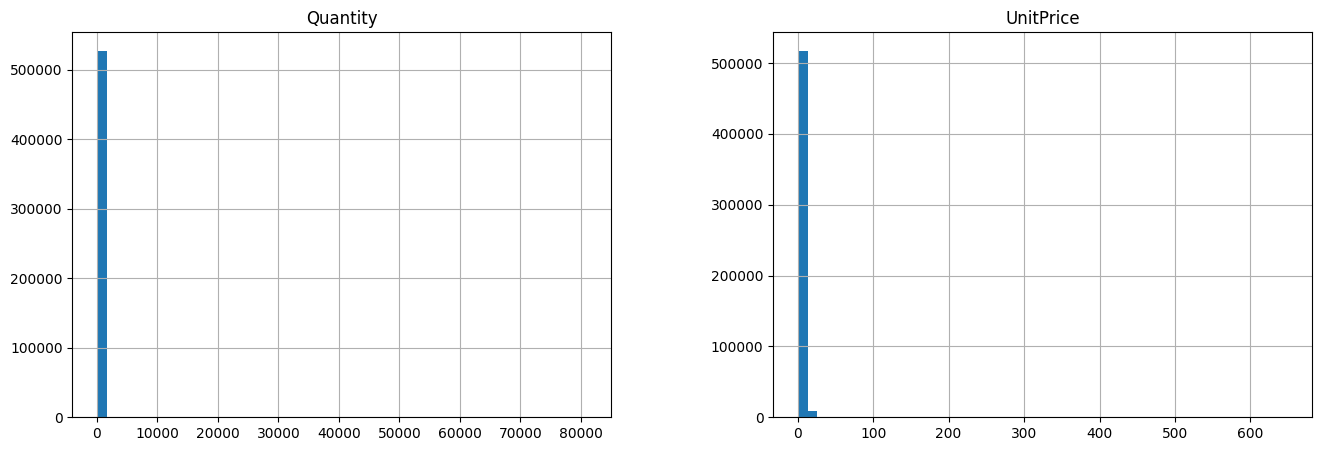

In [16]:
# Check distribution
df[['Quantity', 'UnitPrice']].hist(figsize= (16, 5), bins= 50)
plt.show()

<Axes: >

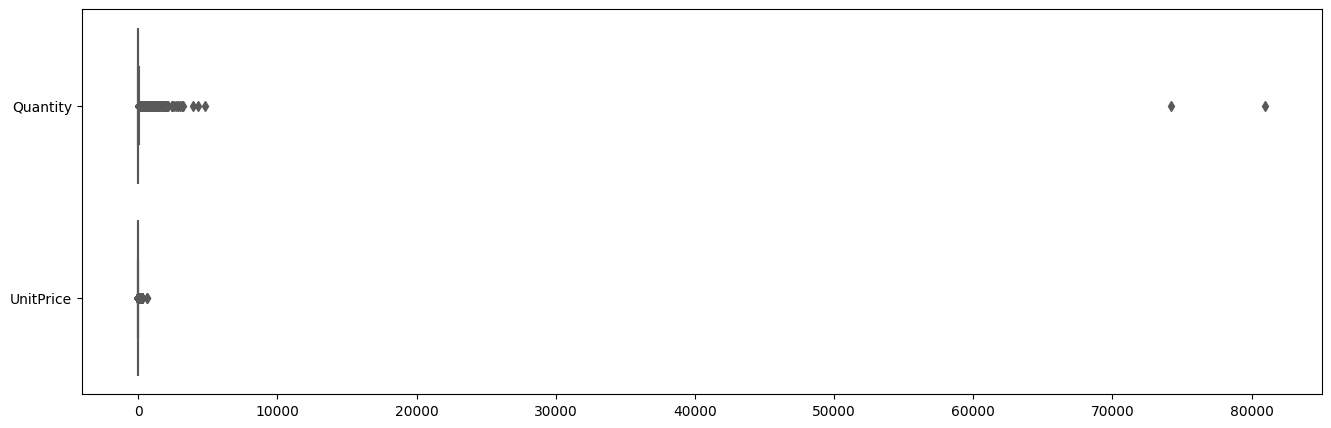

In [17]:
# Check outliners
plt.figure(figsize= (16, 5))
sns.boxplot(df[['Quantity', 'UnitPrice']], orient= 'h', palette= 'Set2')

Both the 'Quantity' and 'UnitPrice' column show outliners. We will have to take care of that.

The most severe outliers are those with more than 10000 in quantity. Let's take a look at them.

In [18]:
# Show most severe outliers
df[(df['Quantity'] > 10000)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
60013,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
526315,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom


These orders are highly improable and should not be included in further analysis.

In [19]:
# Drop the most severe outliers
df = df.drop(df[df['Quantity'] > 10000].index)

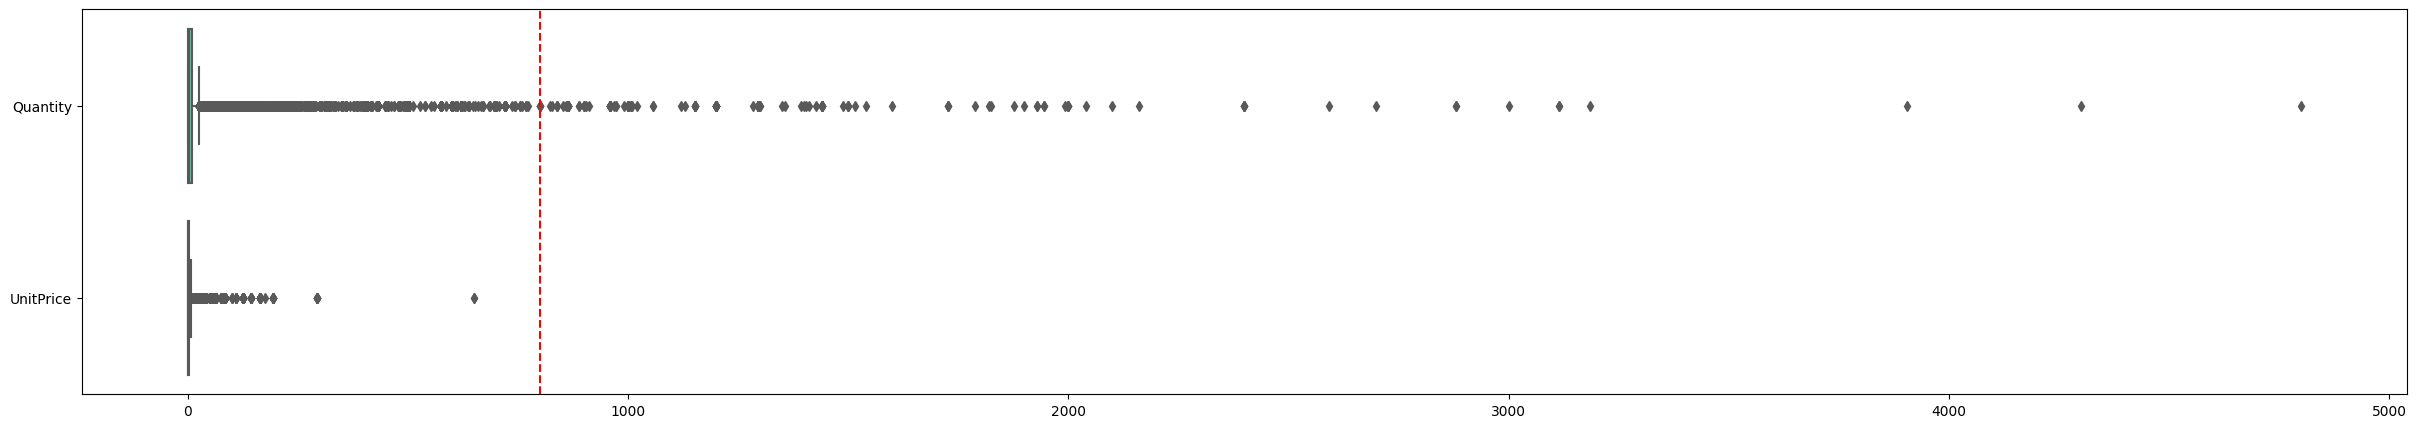

In [20]:
# Check outliners
plt.figure(figsize= (30, 5))
sns.boxplot(df[['Quantity', 'UnitPrice']], orient= 'h', palette= 'Set2')

plt.axvline(x= 800, color= 'red', linestyle= '--')
plt.show()

There are orders with large quantities that stand out, and it would not be appropriate to include them in further analysis, since we are dealing with hundreds of thousands of orders.

In [21]:
# Count more severe outliers in quantity
count = (df['Quantity'] >= 800).sum()
print('Number of orders with more than 800 in quantity: ', count)

Number of orders with more than 800 in quantity:  162


In [22]:
# Drop the more severe outliers
df = df.drop(df[df['Quantity'] >= 800].index)

In [23]:
# Show more severe outliers in unit price
df[(df['UnitPrice'] > 200)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4898,536835,22655,VINTAGE RED KITCHEN CABINET,1,12/2/2010 18:06,295.0,13145.0,United Kingdom
31641,539080,22655,VINTAGE RED KITCHEN CABINET,1,12/16/2010 8:41,295.0,16607.0,United Kingdom
50207,540647,22655,VINTAGE RED KITCHEN CABINET,1,1/10/2011 14:57,295.0,17406.0,United Kingdom
80487,543253,22655,VINTAGE RED KITCHEN CABINET,1,2/4/2011 15:32,295.0,14842.0,United Kingdom
115482,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,3/14/2011 11:38,295.0,13452.0,United Kingdom
130265,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,3/25/2011 14:19,295.0,13452.0,United Kingdom
166244,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,4/28/2011 12:22,295.0,14973.0,United Kingdom
199801,554836,22655,VINTAGE RED KITCHEN CABINET,1,5/26/2011 16:25,295.0,13015.0,United Kingdom
216257,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,6/10/2011 15:28,649.5,15098.0,United Kingdom
216258,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,6/10/2011 15:33,649.5,15098.0,United Kingdom


Although some orders seem odd and like outliers, they should still be included in the analysis. The outliers in quantity are somewhat in acceptable range, whereas expensive products are completely normal.

When the data is clear of unwanted outliers, we may calculate the revenue for each invoice.

In [24]:
# Find the revenue of the sale
df['Revenue'] = df['Quantity'] * df['UnitPrice']

Let's check distribution and outliers of the revenue.

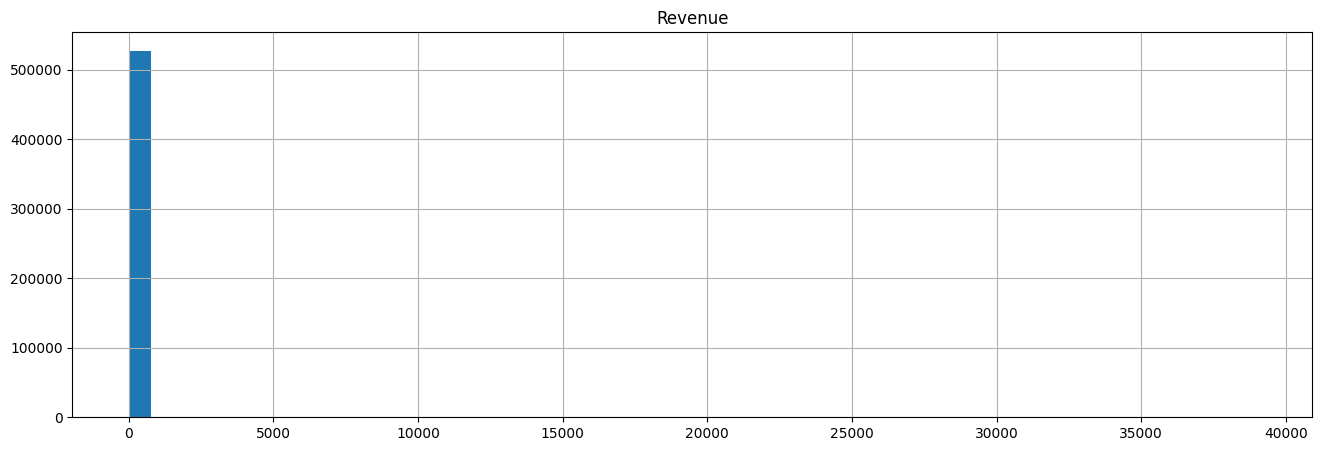

In [25]:
# Check distribution
df[['Revenue']].hist(figsize= (16, 5), bins= 50)
plt.show()

<Axes: >

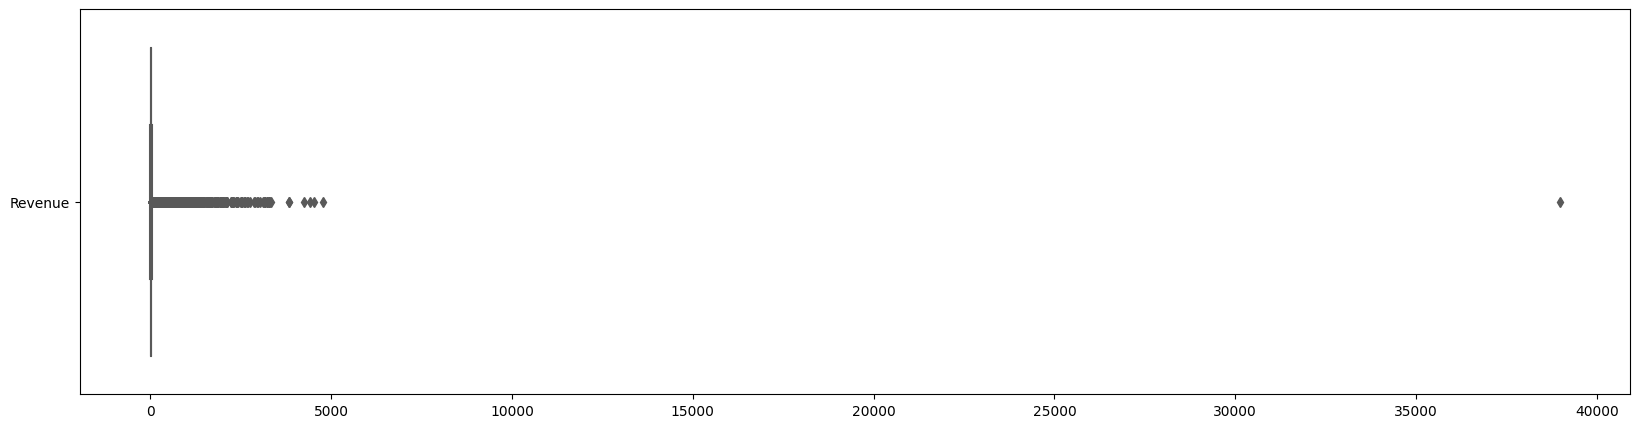

In [26]:
# Check outliners
plt.figure(figsize= (20, 5))
sns.boxplot(df[['Revenue']], orient= 'h', palette= 'Set2')

In [27]:
df[(df['Revenue'] > 10000)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
216257,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,6/10/2011 15:28,649.5,15098.0,United Kingdom,38970.0


In [28]:
df = df.drop(df[df['Revenue'] > 10000].index)

In [29]:
df.reset_index(drop= True, inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527624 entries, 0 to 527623
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    527624 non-null  object 
 1   StockCode    527624 non-null  object 
 2   Description  527624 non-null  object 
 3   Quantity     527624 non-null  int64  
 4   InvoiceDate  527624 non-null  object 
 5   UnitPrice    527624 non-null  float64
 6   CustomerID   396174 non-null  float64
 7   Country      527624 non-null  object 
 8   Revenue      527624 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 36.2+ MB


## 3.3. Finalising

With descriptive analysis, the data is assumed to be sufficiently cleaned and ready for further analysis, but with RFM analysis, the data is yet to be suitable. Thus, we need to create different dataframes for each use.

In [30]:
# Convert date into appropriate type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [31]:
df.to_csv('data (cleaned).csv', index= False)

In [32]:
# Create dataframes for different uses
df_eda = df.copy()
df_rfm = df.dropna()

In [33]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396174 entries, 0 to 527623
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    396174 non-null  object        
 1   StockCode    396174 non-null  object        
 2   Description  396174 non-null  object        
 3   Quantity     396174 non-null  int64         
 4   InvoiceDate  396174 non-null  datetime64[ns]
 5   UnitPrice    396174 non-null  float64       
 6   CustomerID   396174 non-null  float64       
 7   Country      396174 non-null  object        
 8   Revenue      396174 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.2+ MB


# 4. Exploratory Data Analysis (EDA)

In [34]:
# Create colour palette for the visualisations
palette = ['#076B37', '#0D803F', '#0D9A4C', '#3BAD70', '#60BE8C', '#87CBA6']

## 4.1. Descriptive Analysis of the Data

### Overview

In [35]:
df_eda

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
527619,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
527620,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
527621,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
527622,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [36]:
# Count top values for each non-numeric variables
for i in df_eda:
    if df_eda[i].dtypes == 'object':
      print('-----------------------------------------------')
      print(f"\033[32m{i}\033[0m")
      print(df_eda[i].value_counts().head(3))

-----------------------------------------------
InvoiceNo
573585    1113
581219     748
581492     730
Name: InvoiceNo, dtype: int64
-----------------------------------------------
StockCode
85123A    2261
85099B    2109
22423     2017
Name: StockCode, dtype: int64
-----------------------------------------------
Description
WHITE HANGING HEART T-LIGHT HOLDER    2319
JUMBO BAG RED RETROSPOT               2109
REGENCY CAKESTAND 3 TIER              2017
Name: Description, dtype: int64
-----------------------------------------------
Country
United Kingdom    483884
Germany             8658
France              8099
Name: Country, dtype: int64


UK customer, or rather domestic customer, is accounted for the majority of all orders. We need to find deeper insights into that.

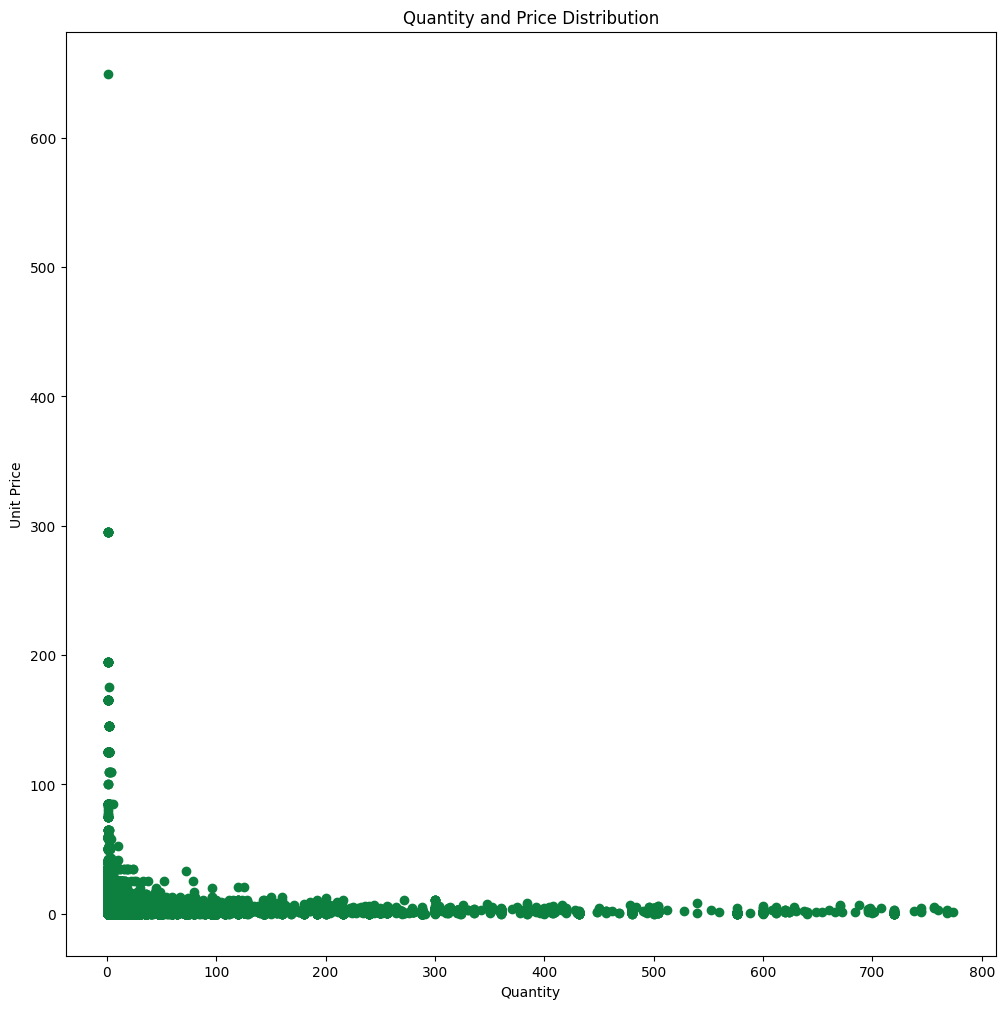

In [37]:
# Show distribution of quantity and price per unit
plt.figure(figsize= (12,12))
plt.scatter(df_eda['Quantity'], df_eda['UnitPrice'], color= palette[1])
plt.title('Quantity and Price Distribution')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')
plt.show()

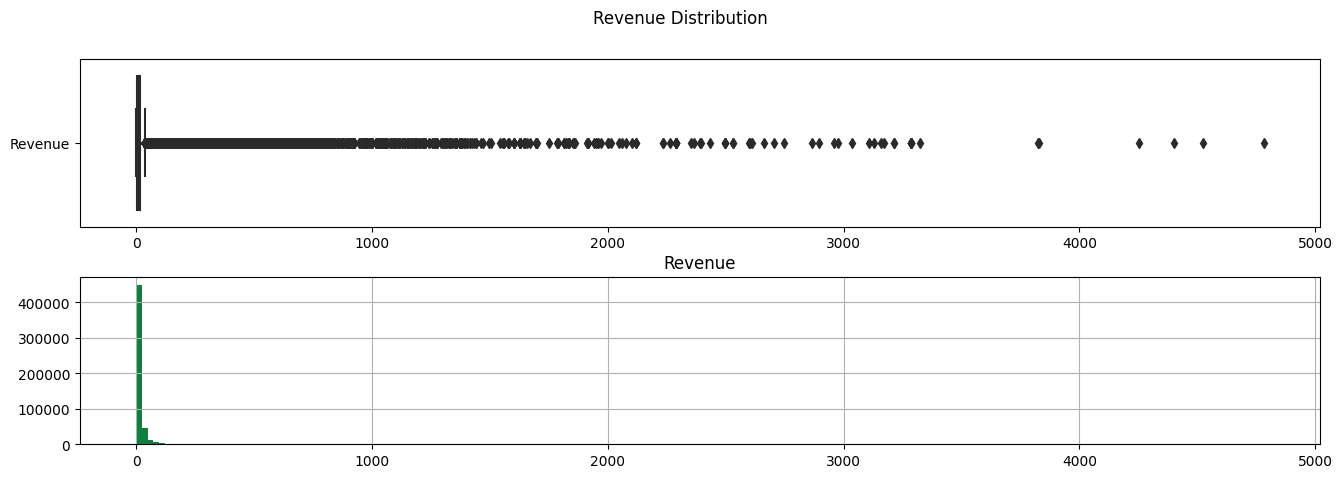

In [38]:
# Show distribution of revenue
fig = plt.figure(figsize= (16,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.boxplot(df[['Revenue']], orient= 'h', color= palette[1], ax= ax1)
df[['Revenue']].hist(bins= 200, color= palette[1], ax= ax2)

fig.suptitle('Revenue Distribution')
plt.show()


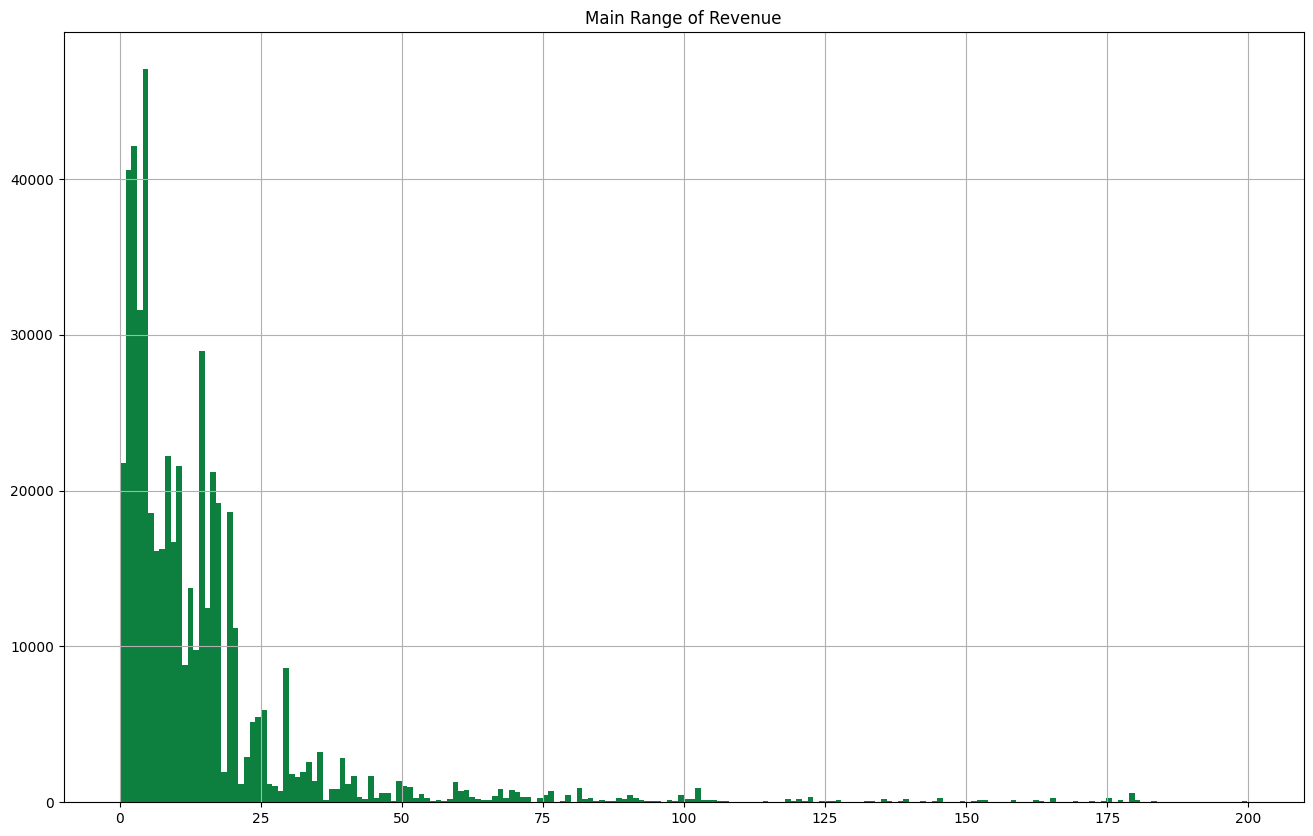

In [39]:
# Show the main distribution of revenue
revenue_range = df_eda[(df_eda['Revenue'] < 200)]

fig, ax = plt.subplots(figsize= (16, 10))
revenue_range[['Revenue']].hist(bins= 200, color= palette[1], ax= ax)
ax.set_title('Main Range of Revenue')
plt.show()


The revenue per order is usually less then 25 GBP.

### Revenue in Top Countries

In [40]:
# Find top countries by sales value
top_countries = df_eda.groupby('Country')['Revenue'].sum().sort_values(ascending= False)[:5]
other_sales = df_eda.groupby('Country')['Revenue'].sum().sort_values(ascending= False)[5:].sum()
other_sales = pd.Series({'Others': other_sales})

sales_by_countries = pd.concat([top_countries, other_sales])
sales_by_countries

United Kingdom    8271934.88
Netherlands        272574.78
EIRE               270530.70
Germany            205569.89
France             182950.26
Others             567148.73
dtype: float64

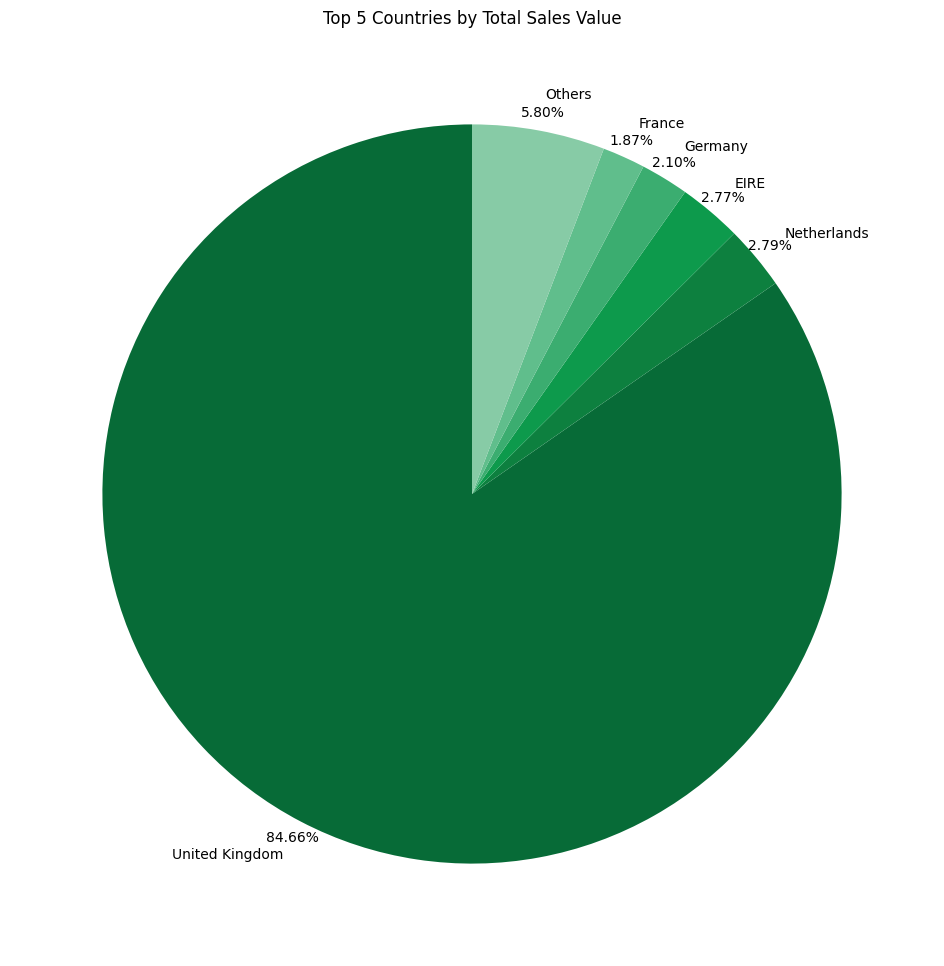

In [41]:
# Show top countries by sales value
plt.figure(figsize= (12,12))
plt.pie(sales_by_countries, labels= sales_by_countries.index, autopct= '%1.2f%%', startangle= 90, pctdistance= 1.05, colors= palette)
plt.title('Top 5 Countries by Total Sales Value')
plt.show()


Domestic customers account for around 85% of the total customers. This online retail store finds itself more appealing for the domestic customers rather tham overseas customers.

### Top Purchased Products

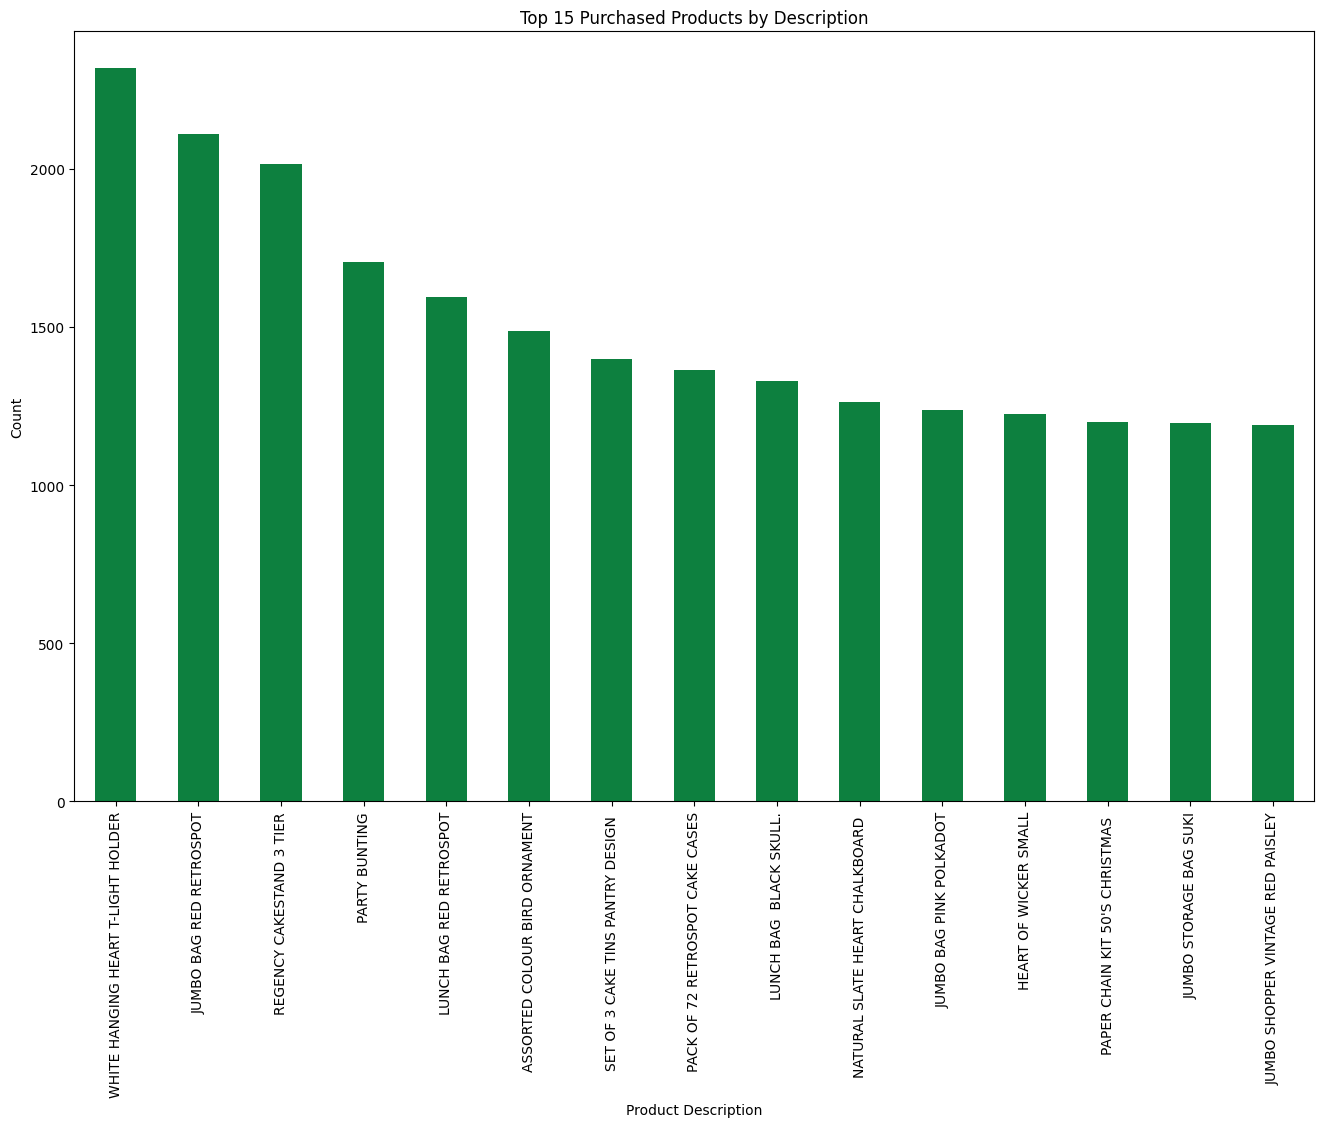

In [42]:
# Find top products
top15_product_description = df['Description'].value_counts().head(15)

# Show top products
plt.figure(figsize= (16,10))
top15_product_description.plot.bar(color= palette[1])

plt.title('Top 15 Purchased Products by Description')
plt.xlabel('Product Description')
plt.ylabel('Count')
plt.show()


Top 3 products that stand out more from the list are: White Hanging Heart T-Light Holder, Jumbo Bag Red Retrospot, and Regency Cakestand 3 Tier.

### Monthly Revenue and Order

In [43]:
# Find monthly revenue and order
monthly_revenue_order = df_eda.groupby(pd.Grouper(key= 'InvoiceDate', freq= 'M')).agg({'Revenue': 'sum', 'InvoiceNo': 'count'})
monthly_revenue_order.reset_index(inplace= True)
monthly_revenue_order['InvoiceDate'] = monthly_revenue_order['InvoiceDate'].dt.strftime('%m-%Y')
monthly_revenue_order = monthly_revenue_order.rename(columns= {'Revenue': 'Monthly Revenue', 'InvoiceNo': 'Monthly Order'})
monthly_revenue_order.tail(5)

,InvoiceDate,Monthly Revenue,Monthly Order
8,08-2011,714781.80,34322
9,09-2011,1004842.68,49042
10,10-2011,1082733.53,59052
11,11-2011,1432239.47,83076
12,12-2011,429174.80,25021


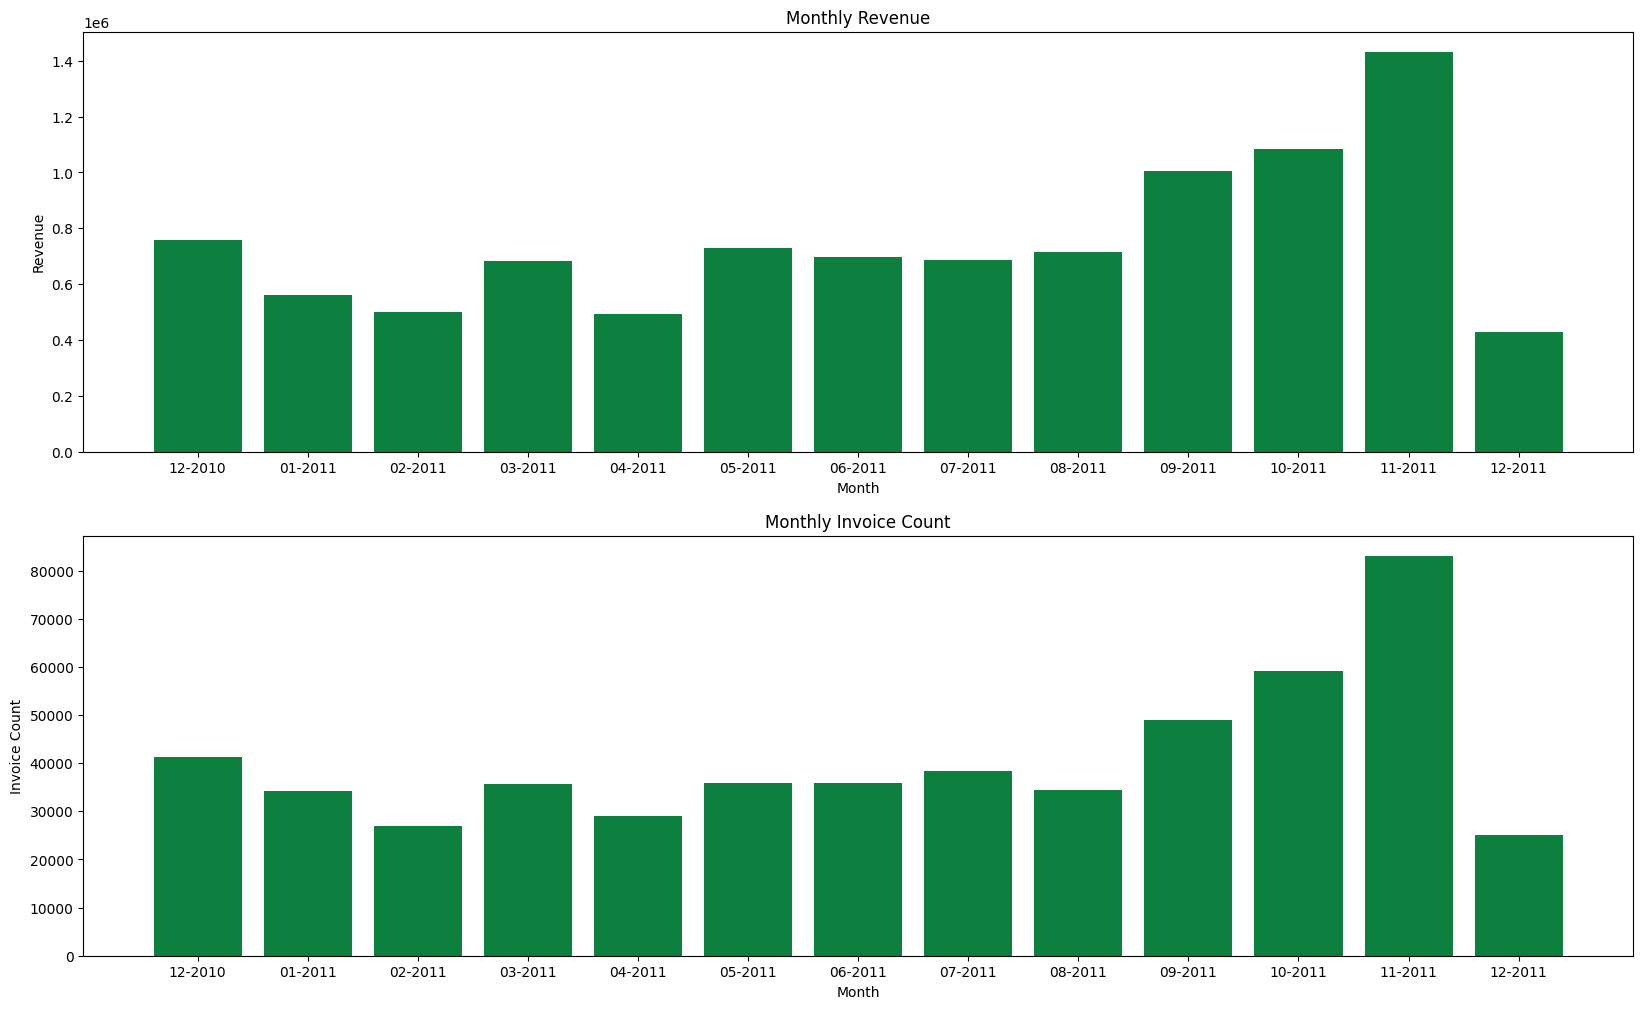

In [44]:
# Show monthly revenue and order
fig = plt.figure(figsize= (20, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.bar(monthly_revenue_order['InvoiceDate'], monthly_revenue_order['Monthly Revenue'], color= palette[1])
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue')
ax1.set_title('Monthly Revenue')

ax2.bar(monthly_revenue_order['InvoiceDate'], monthly_revenue_order['Monthly Order'], color= palette[1])
ax2.set_xlabel('Month')
ax2.set_ylabel('Invoice Count')
ax2.set_title('Monthly Invoice Count')

plt.show()

Both 2 graphs shows a somewhat similar trend in monthly figures.

The figures in monthly revenue and invoice witnessed a fluctuation throughout the year. Especially, there was less revenue and order in February and April, while August had a drop in order but a stable revenue.

Towards the end of the year (September to November), both the revenue and invoice count went up significantly, and this is a positive sign for the status of the store.

As mentioned above in part 1: "Understanding the Data", the data appears to hold the record to December 9, 2011 only, without mentioning the rest of the month. This month will not be considered suitable for analysis.

### Customer Types

In [45]:
# Create a new column with the earliest invoice date for each customer and column for customer type
df_eda['CustomerFirstPurchase'] = df_eda.groupby('CustomerID')['InvoiceDate'].transform('min')
df_eda['CustomerType'] = np.nan
df_eda


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,CustomerFirstPurchase,CustomerType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01 08:26:00,NaN
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01 08:26:00,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
527619,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-08-18 15:44:00,NaN
527620,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-08-18 15:44:00,NaN
527621,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-08-18 15:44:00,NaN
527622,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-08-18 15:44:00,NaN


In [46]:
# Assign customer types
is_new_customer = df_eda['CustomerFirstPurchase'] == df_eda['InvoiceDate']

df_eda['CustomerType'] = np.nan
df_eda.loc[is_new_customer, 'CustomerType'] = 'New Customer'
df_eda.loc[~is_new_customer, 'CustomerType'] = 'Existing Customer'
df_eda.drop(['CustomerFirstPurchase'], axis= 1, inplace= True)

df_eda

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,CustomerType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,New Customer
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,New Customer
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,New Customer
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,New Customer
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,New Customer
...,...,...,...,...,...,...,...,...,...,...
527619,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,Existing Customer
527620,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,Existing Customer
527621,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,Existing Customer
527622,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,Existing Customer


In [47]:
# Group customer types by month
new_customer = df_eda[df_eda['CustomerType'] == 'New Customer'].groupby(pd.Grouper(key= 'InvoiceDate', freq= 'M')).agg({'CustomerType': 'count'})
existing_customer = df_eda[df_eda['CustomerType'] == 'Existing Customer'].groupby(pd.Grouper(key= 'InvoiceDate', freq= 'M')).agg({'CustomerType': 'count'})

new_customer.reset_index(inplace= True)
existing_customer.reset_index(inplace= True)

new_customer['InvoiceDate'] = new_customer['InvoiceDate'].dt.strftime('%m-%Y')
existing_customer['InvoiceDate'] = existing_customer['InvoiceDate'].dt.strftime('%m-%Y')
new_customer

,InvoiceDate,CustomerType
0,12-2010,18876
1,01-2011,10134
2,02-2011,8301
3,03-2011,10647
4,04-2011,6685
5,05-2011,5670
6,06-2011,5354
7,07-2011,4491
8,08-2011,4652
9,09-2011,7573


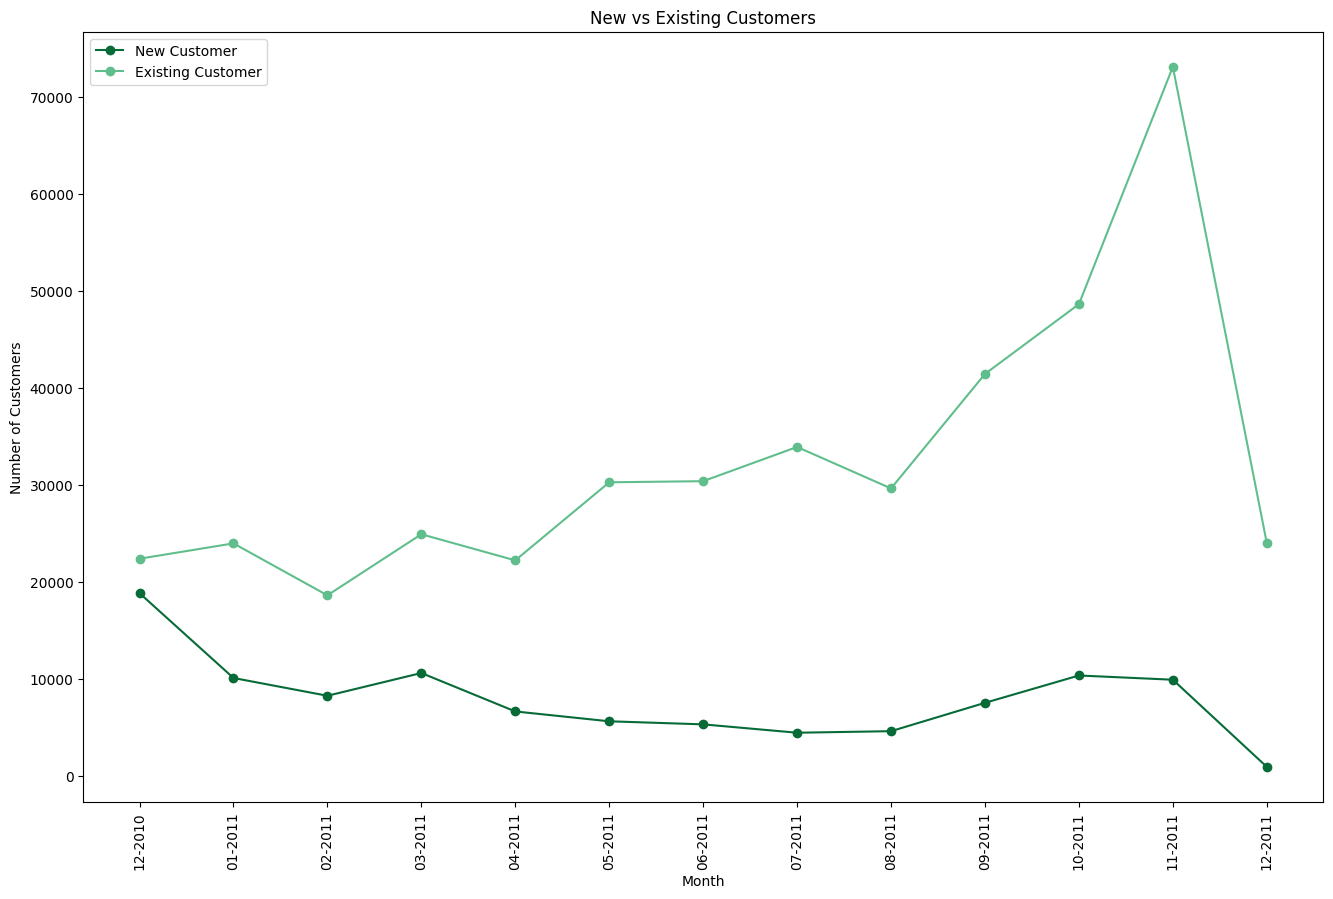

In [48]:
# Show customer types by month
plt.figure(figsize= (16,10))
plt.plot(new_customer['InvoiceDate'], new_customer['CustomerType'], color= palette[0], label= 'New Customer', marker= 'o')
plt.plot(existing_customer['InvoiceDate'], existing_customer['CustomerType'], color= palette[4], label= 'Existing Customer', marker= 'o')

plt.title('New vs Existing Customers')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.xticks(rotation= 90)

plt.legend()
plt.show()

There are key insights about the customers:
* On one hand, the figure of new customers matches the trend of the count of orders per month. This number dropped in February, April, and August, while more than tripled in November compared to last December.
* On the other hand, the number of existing customers gradually decreased. It did go up in September like other figures, but in November, it surprisingly slightly decreased, much opposed to the burst in new customers.

Again, the data appears to hold the record to December 9, 2011 only, without mentioning the rest of the month. This month will not be considered suitable for analysis.


## 4.2. RFM Scores

In [49]:
# Define a function creating a RFM table
def make_rfm(data, customer, date, invoice, sales):
    # Find latest purchase date
    latest_date = data[date].max() + timedelta(1)
    
    # Create RFM features
    rfm_score = data.groupby(customer).apply(lambda x: pd.Series({
        'Recency': (latest_date - x[date].max()).days,
        'Frequency': len(x[invoice]),
        'Monetary': x[sales].sum()
    }))
    
    # Cast appropriate types to columns
    rfm_score['Recency'] = rfm_score['Recency'].astype(int)
    rfm_score['Frequency'] = rfm_score['Frequency'].astype(int)

    return rfm_score.reset_index()


In [50]:
# Find RFM for data
df_rfm_score = make_rfm(df_rfm, 'CustomerID', 'InvoiceDate', 'InvoiceNo', 'Revenue')

As decribed above in part 3 (Data Cleaning and Preparing), column for Customer ID has type float, and we need to convert it to string to find the description of it.

In [51]:
# Change CustomerID to appropriate type
df_rfm_score['CustomerID'] = df_rfm_score['CustomerID'].astype(str)
df_rfm_score.head(5)

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,182,4310.00
1,12348.0,75,27,1437.24
2,12349.0,19,72,1457.55
3,12350.0,310,16,294.40
4,12352.0,36,77,1385.74


In [52]:
df_rfm_score.describe()

,Recency,Frequency,Monetary
count,4326.000000,4326.000000,4326.000000
mean,92.652335,91.579750,1910.635580
std,100.073898,228.153238,8003.868205
min,1.000000,1.000000,2.900000
25%,18.000000,17.000000,304.040000
50%,51.000000,41.000000,663.905000
75%,143.000000,100.000000,1619.470000
max,374.000000,7838.000000,267823.460000


In [53]:
df_rfm_score.describe(include= 'object')

,CustomerID
count,4326
unique,4326
top,12347.0
freq,1


In [54]:
# Plot the RFM table
fig = px.scatter_3d(df_rfm_score, x= df_rfm_score['Recency'], y= df_rfm_score['Frequency'], z= df_rfm_score['Monetary'], 
                 color_discrete_sequence= [palette[1]])

fig.update_layout(title_text= 'RFM 3D Plot',
                    scene = dict(xaxis= dict(backgroundcolor= 'white',
                                          color= 'black',
                                          gridcolor= 'lightgrey'),
                               yaxis= dict(backgroundcolor= 'white',
                                          color= 'black',
                                          gridcolor= 'lightgrey'
                                          ),
                               zaxis= dict(backgroundcolor= 'white',
                                          color= 'black', 
                                          gridcolor= 'lightgrey')),
                    width= 800,
                    height= 800)

fig.update_traces(marker= dict(size= 3))

fig.show()

The store has attracted more than 4000 customers, with the total number of transactions of more than 500000.
It's essential to notice that most of the customers stay in a particular range of RFM features.

However, there seems to be some customers with large RFM scores. In fact, a big recency number is normal, for it can be interpreted as the last time that customer purchased from the store was a long time ago. The unusual case lies in the big frequency and monetary score: some customers buy more than 1000 times, or some paid up for 100,000 GBP, which all seems to be highly unusual.

Nonetheless, it would be better to still include them in the analysis and modelling, and they should be categorised in a special group.

# 5. Model Building

In [55]:
# Prepare data for modelling
X = df_rfm_score[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.90595866,  0.39635949,  0.29981026],
       [-0.17641339, -0.283087  , -0.05915269],
       [-0.73606455, -0.08582834, -0.05661487],
       ...,
       [-0.84599603, -0.34883989, -0.21649355],
       [-0.88597112,  2.90373624,  0.02227861],
       [-0.49621405, -0.09459539, -0.00916608]])

In [56]:
X_scaled.shape

(4326, 3)

## 5.1. K-Means Clustering

Let's find the number of clusters using Silhouette method.

In [57]:
kmean_silhouette_scores = []
k_range = range(2, 11)

# Find the silhouette scores
for i in k_range:
    kmeans = KMeans(n_clusters= i, max_iter= 200, init= 'k-means++', n_init= 10, random_state= 0)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    kmean_silhouette_scores.append(score)

In [58]:
# Take a look at the numbers of clusters and their respective silhouette score
k_dict_kmean = {'Number of Clusters': list(k_range), 'Silhouette Score': kmean_silhouette_scores}
clusters_kmean = pd.DataFrame(k_dict_kmean)
clusters_kmean

,Number of Clusters,Silhouette Score
0,2,0.933662
1,3,0.599477
2,4,0.598206
3,5,0.617381
4,6,0.589973
5,7,0.521449
6,8,0.505068
7,9,0.509613
8,10,0.462664


Based on the silhouette score, k = 2 is the optimal score. However, splitting customers into 2 group is probably too generalised.
* The runner-up for the best score is k = 5.
* The next scores are 6 and 7, but splitting customers into 6-7 groups can be too much, regardess we may check them if it's necessary.
* Splitting customers into 3-4 group can be well adjusted, but given their silhouette scores, they may not perform the best. Nonetheless it's still good to take a look at them.

Since there are only 3 factors revolvign this customer segmentation, we can well visualise the clusters in a 3D scatter plot.

In [59]:
# Define a function visualising the clusters
def check_kmeans(data, i):
    kmeans = KMeans(n_clusters= i, max_iter= 200, init= 'k-means++', n_init= 10, random_state= 0)
    kmeans_result = kmeans.fit_predict(data)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    labels = [j+1 for j in range(0,i)]

    for j in range(i):
        ax.scatter(X_scaled[kmeans_result == j, 0], X_scaled[kmeans_result == j, 1], X_scaled[kmeans_result == j, 2], label= labels[j])
    
    ax.set_title(f'Customer Segmentation: K-Means {i} Clusters')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    plt.legend()

    plt.show()

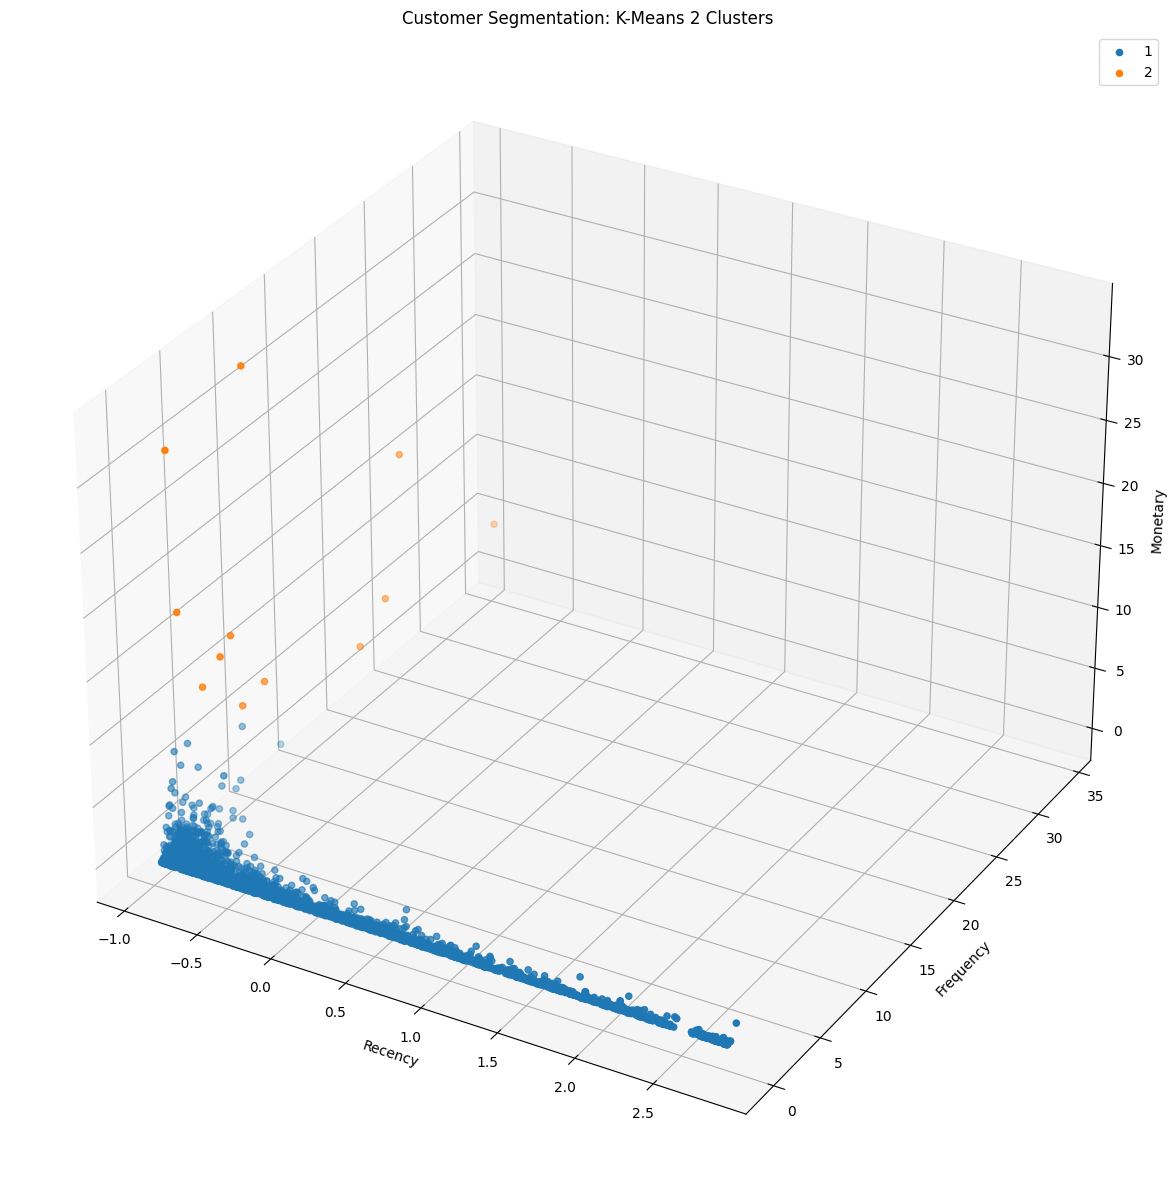

In [60]:
check_kmeans(X_scaled, 2)

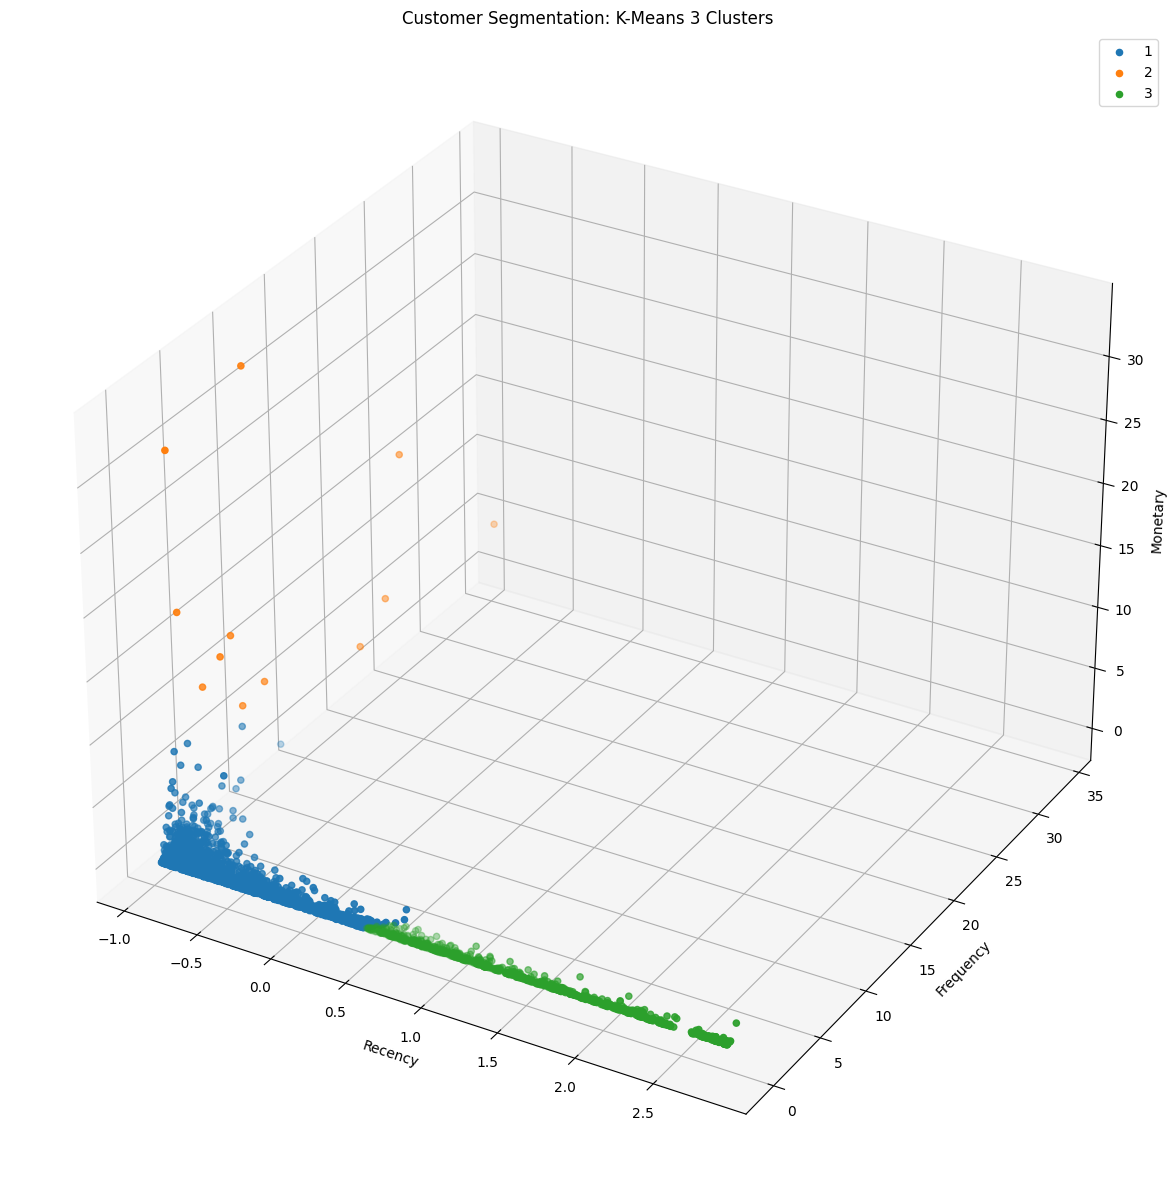

In [61]:
check_kmeans(X_scaled, 3)

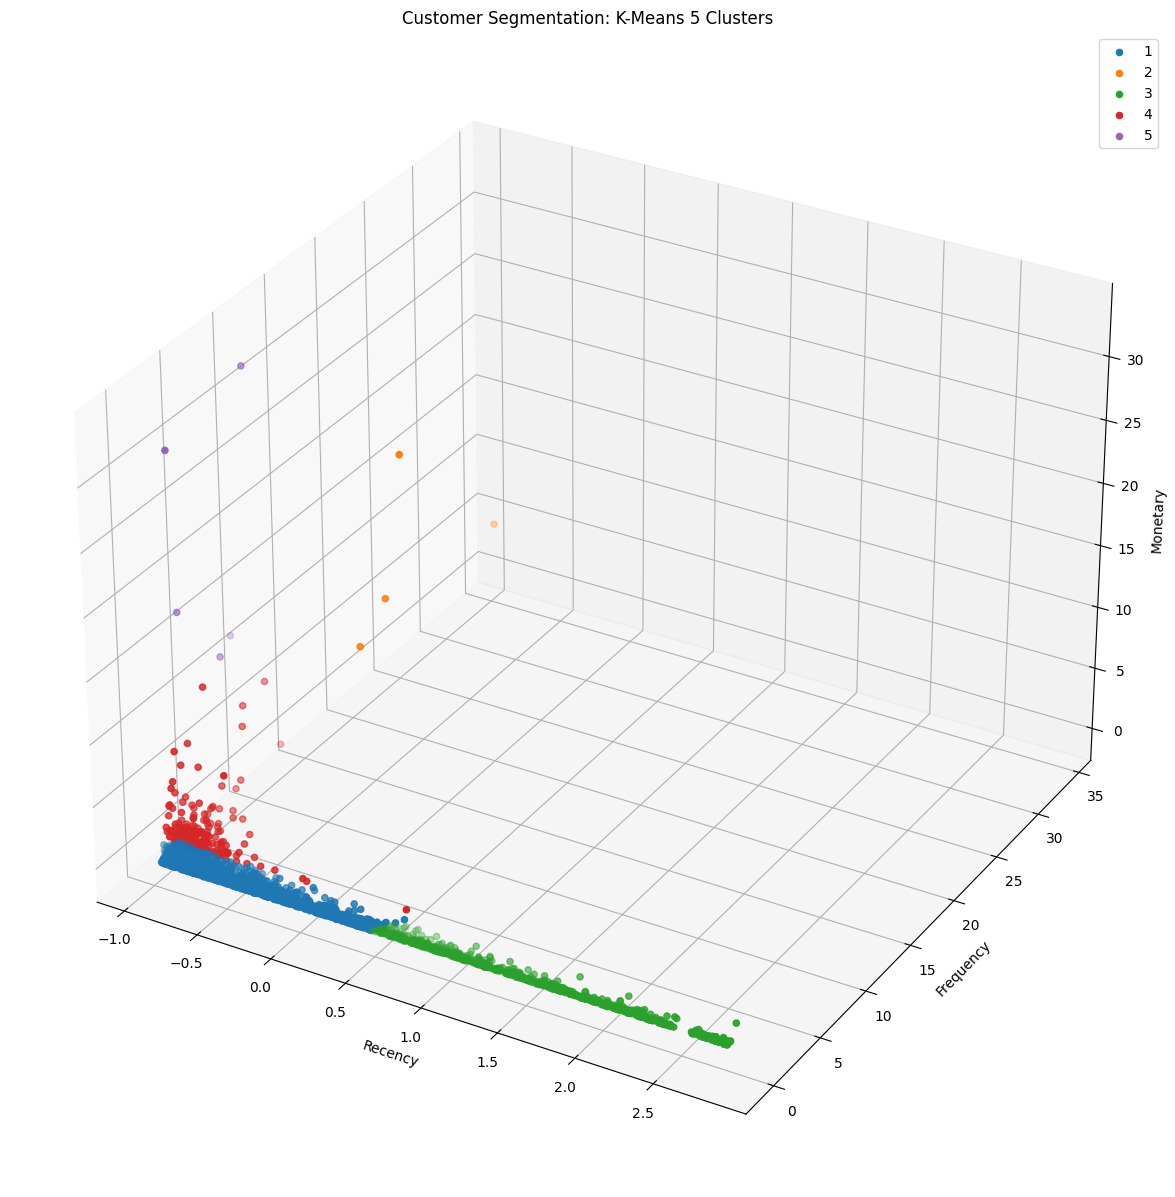

In [62]:
check_kmeans(X_scaled, 5)

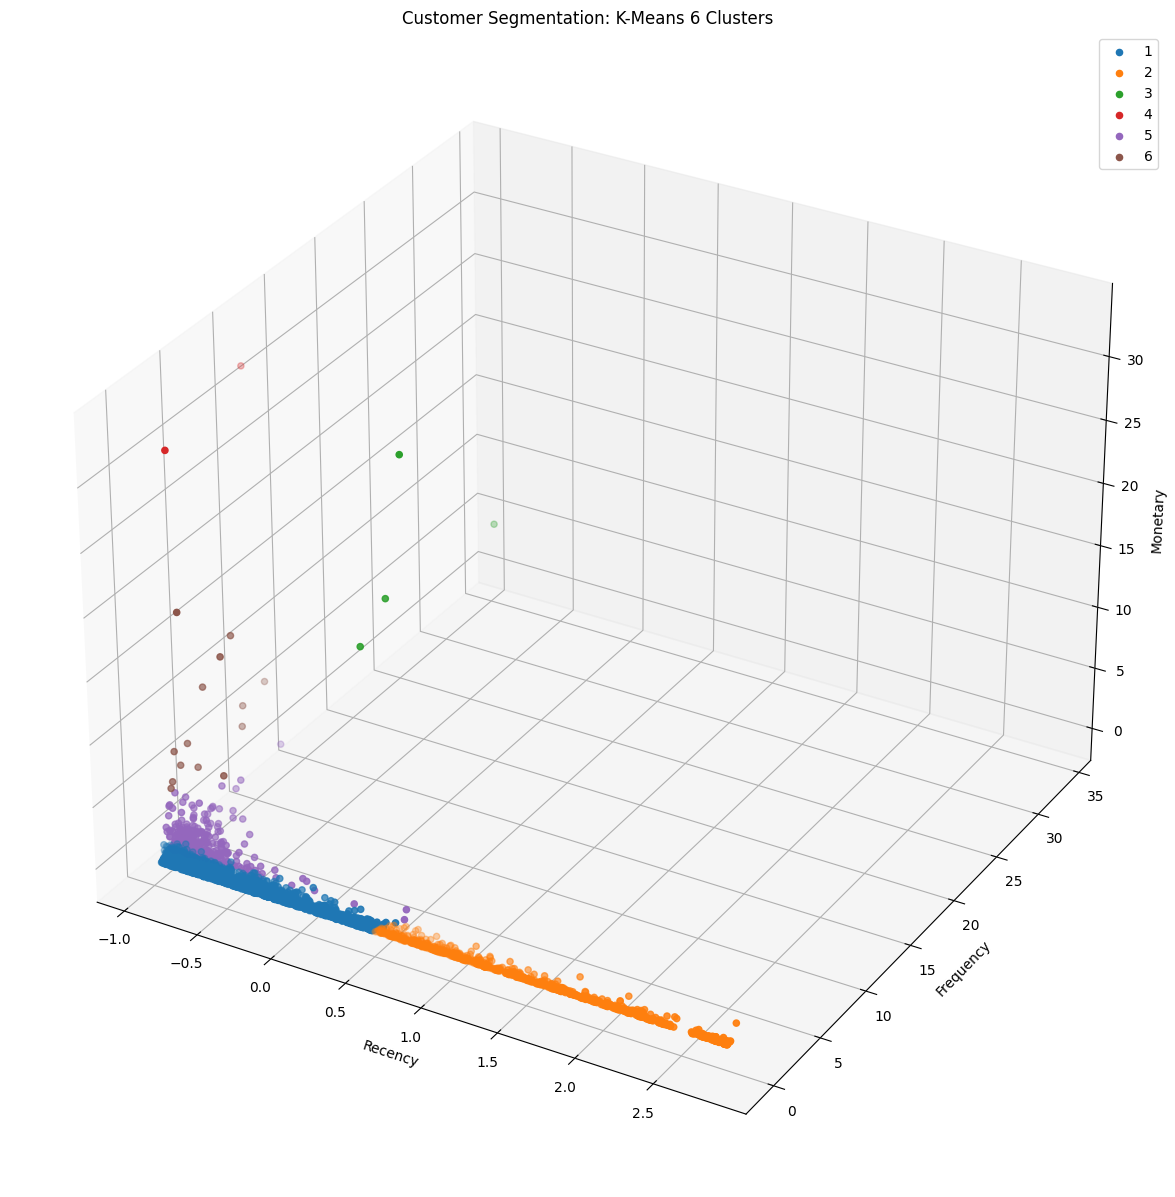

In [63]:
check_kmeans(X_scaled, 6)

There are a few conclusions to be made:
* k = 2 is indeed too generalised.
* k = 3 is still too generalised.
* k = 5 may produce a good silhouettte score, but k = 6 does it better at identifying bigger recency.

In short, k = 6 is the suitable number of clusters.

In [64]:
kmeans = KMeans(n_clusters= 6, max_iter= 200, init= 'k-means++', n_init= 10, random_state= 0)
kmeans.fit_predict(X_scaled)
df_rfm_score['K-means Clustering'] = kmeans.labels_
df_rfm_score

,CustomerID,Recency,Frequency,Monetary,K-means Clustering
0,12347.0,2,182,4310.00,0
1,12348.0,75,27,1437.24,0
2,12349.0,19,72,1457.55,0
3,12350.0,310,16,294.40,1
4,12352.0,36,77,1385.74,0
...,...,...,...,...,...
4321,18280.0,278,10,180.60,1
4322,18281.0,181,7,80.82,1
4323,18282.0,8,12,178.05,0
4324,18283.0,4,754,2088.93,4


## 5.2. Hierarchical Clustering

Hierarchical Clustering is more complicated in terms of which linkage to be used. Thus, finding out the linkage should be the priorrity.

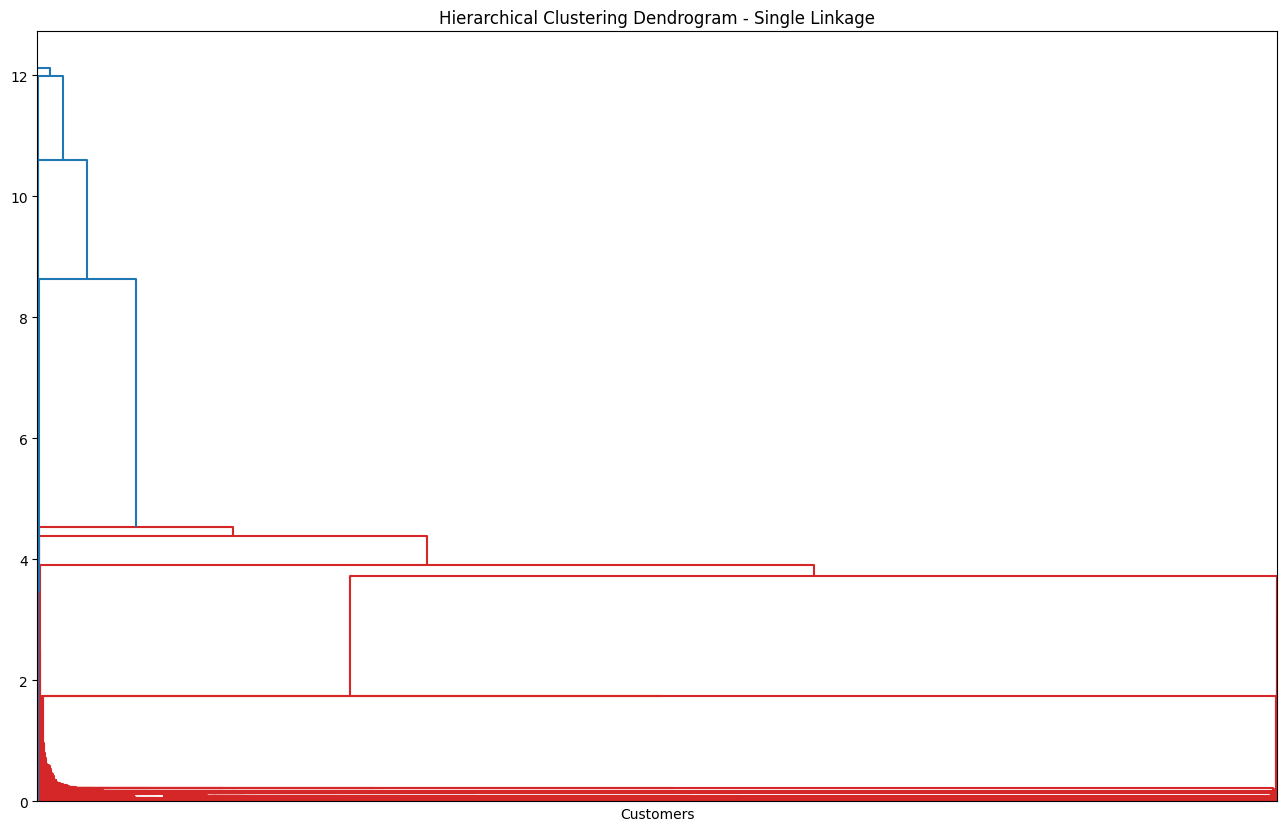

In [65]:
# Plot linkage: single
hc_single = hierarchy.linkage(X_scaled, method= 'single')

plt.figure(figsize= (16, 10))
hierarchy.dendrogram(hc_single)
plt.title('Hierarchical Clustering Dendrogram - Single Linkage')
plt.xlabel('Customers')
plt.ylabel('')
plt.xticks([])
plt.show()


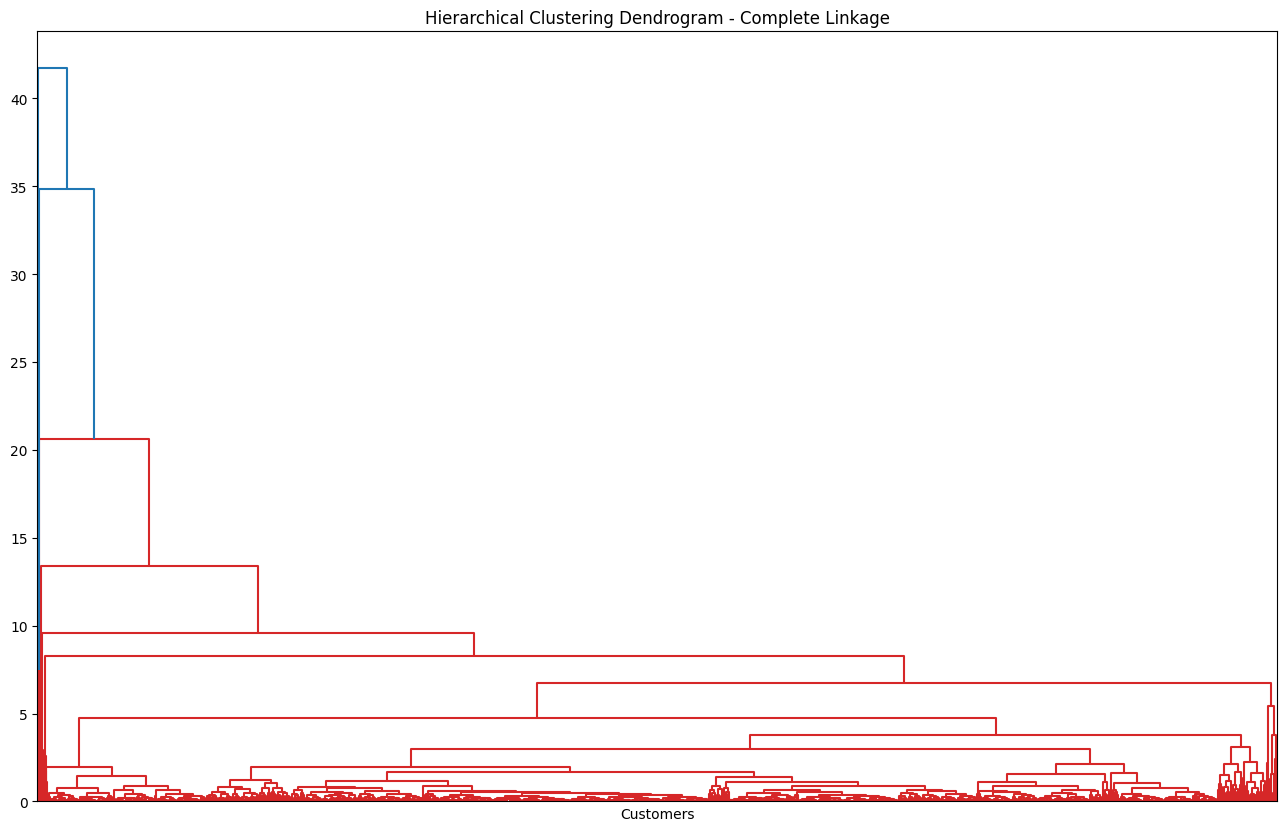

In [66]:
# Plot linkage: complete
hc_complete = hierarchy.linkage(X_scaled, method= 'complete')

plt.figure(figsize= (16, 10))
hierarchy.dendrogram(hc_complete)
plt.title('Hierarchical Clustering Dendrogram - Complete Linkage')
plt.xlabel('Customers')
plt.ylabel('')
plt.xticks([])
plt.show()


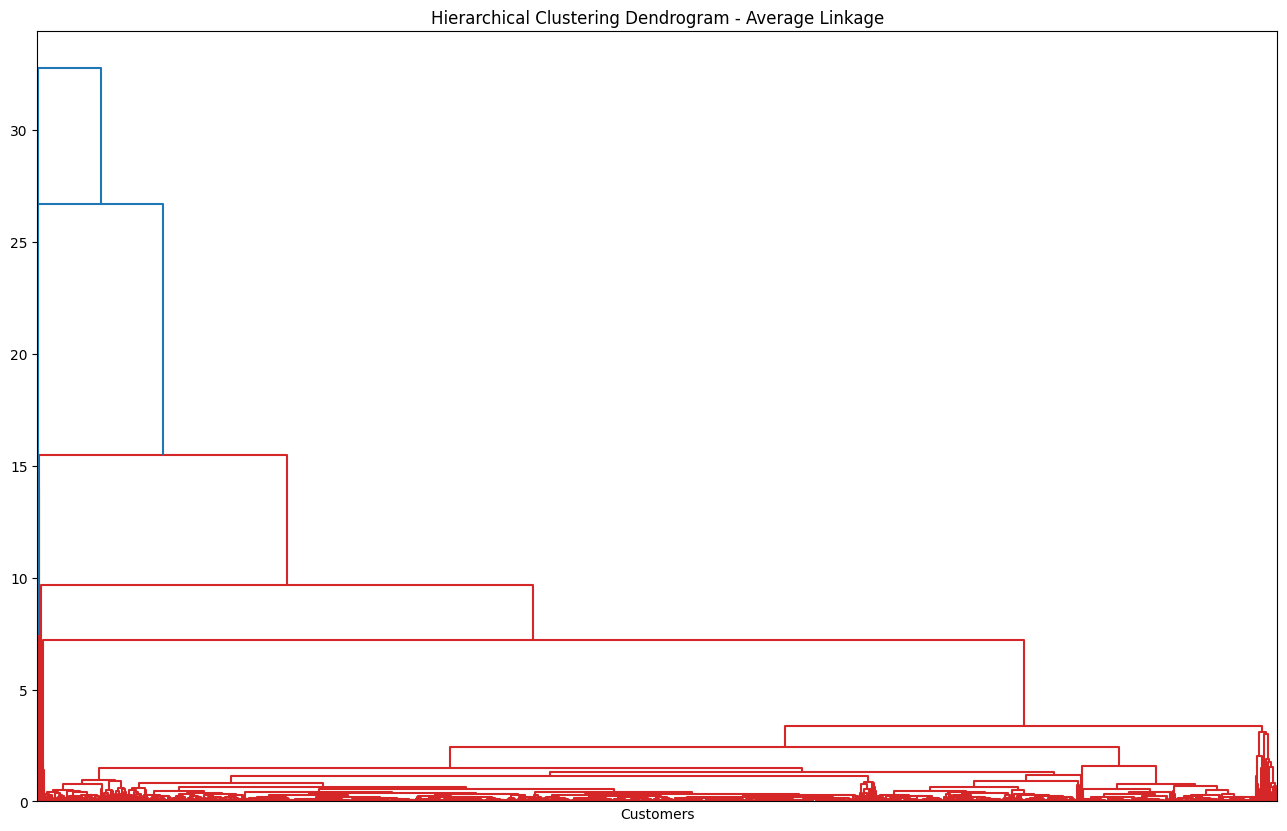

In [67]:
# Plot linkage: average
hc_average = hierarchy.linkage(X_scaled, method= 'average')

plt.figure(figsize= (16, 10))
hierarchy.dendrogram(hc_average)
plt.title('Hierarchical Clustering Dendrogram - Average Linkage')
plt.xlabel('Customers')
plt.ylabel('')
plt.xticks([])
plt.show()


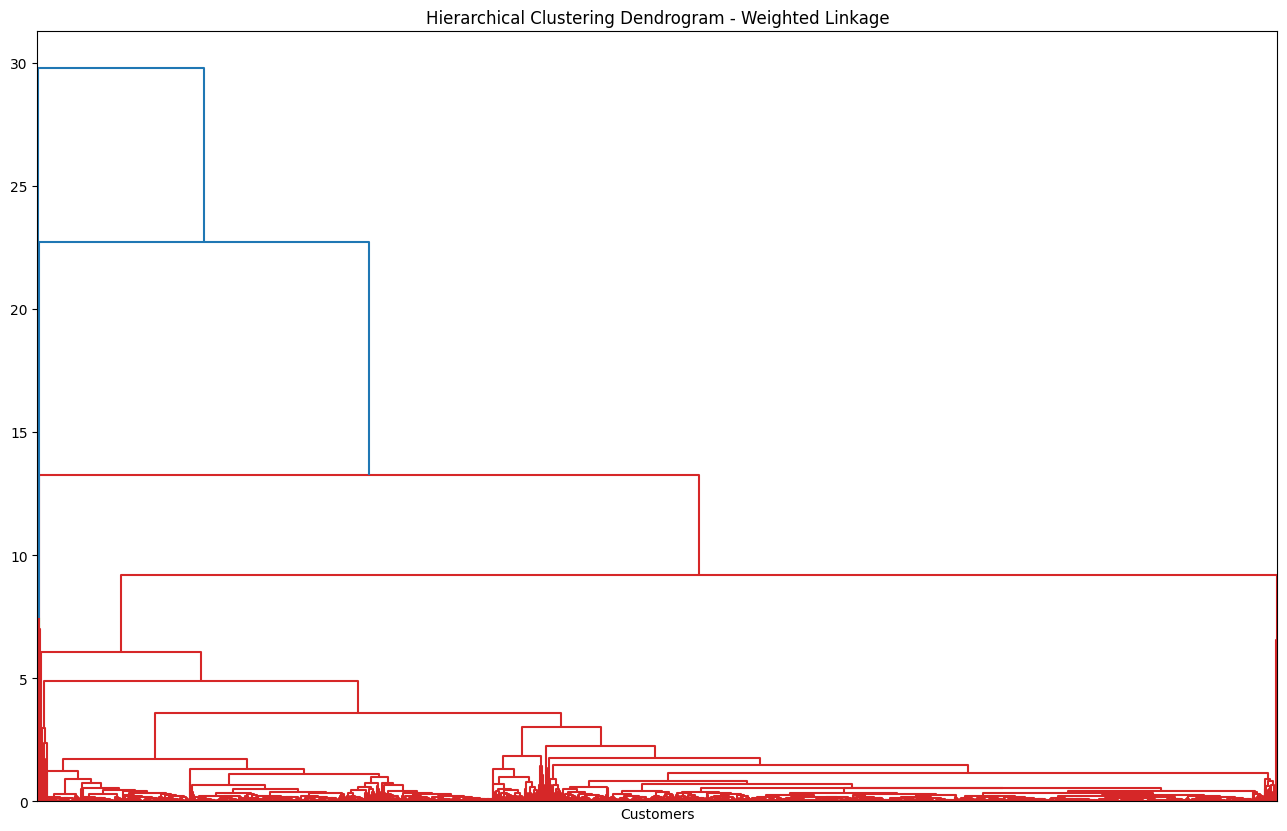

In [68]:
# Plot linkage: weighted
hc_weighted = hierarchy.linkage(X_scaled, method= 'weighted')

plt.figure(figsize= (16, 10))
hierarchy.dendrogram(hc_weighted)
plt.title('Hierarchical Clustering Dendrogram - Weighted Linkage')
plt.xlabel('Customers')
plt.ylabel('')
plt.xticks([])
plt.show()


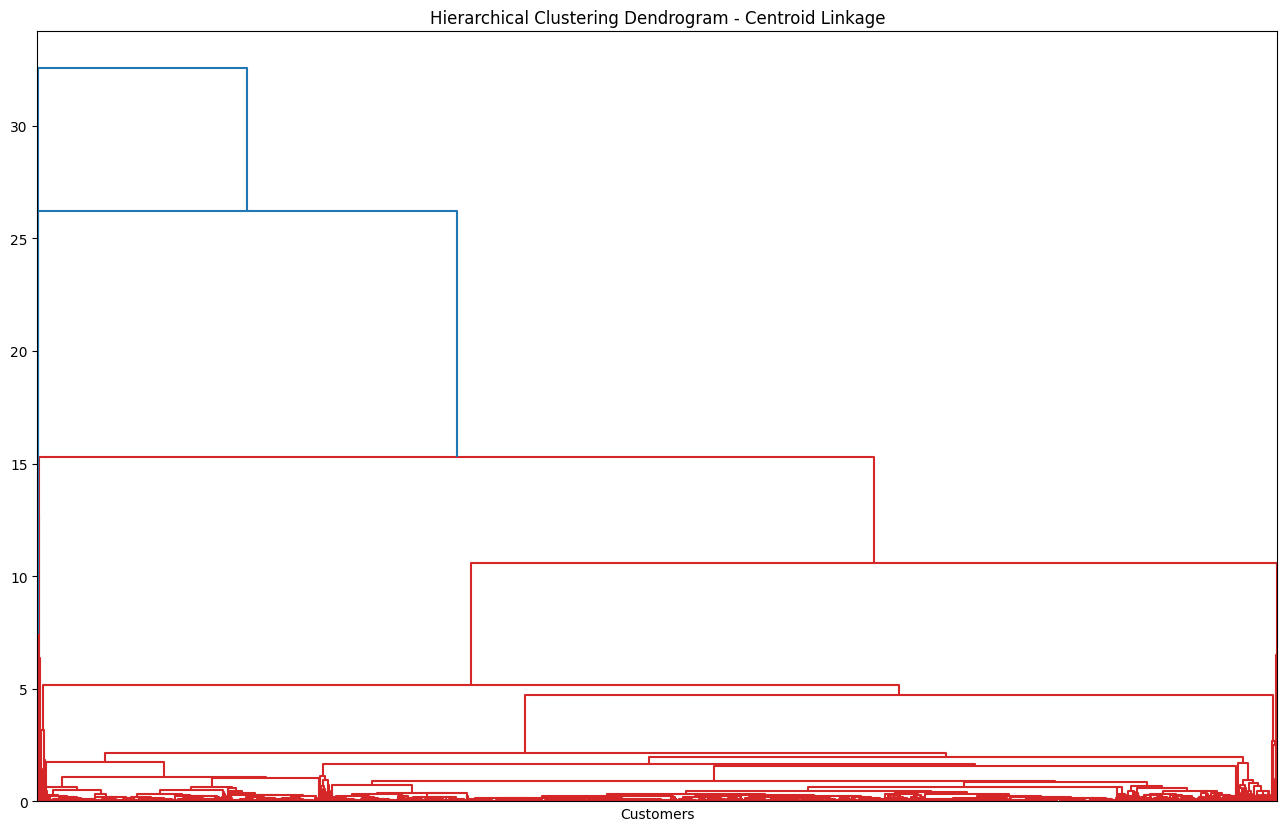

In [69]:
# Plot linkage: centroid
hc_centroid = hierarchy.linkage(X_scaled, method= 'centroid')

plt.figure(figsize= (16, 10))
hierarchy.dendrogram(hc_centroid)
plt.title('Hierarchical Clustering Dendrogram - Centroid Linkage')
plt.xlabel('Customers')
plt.ylabel('')
plt.xticks([])
plt.show()


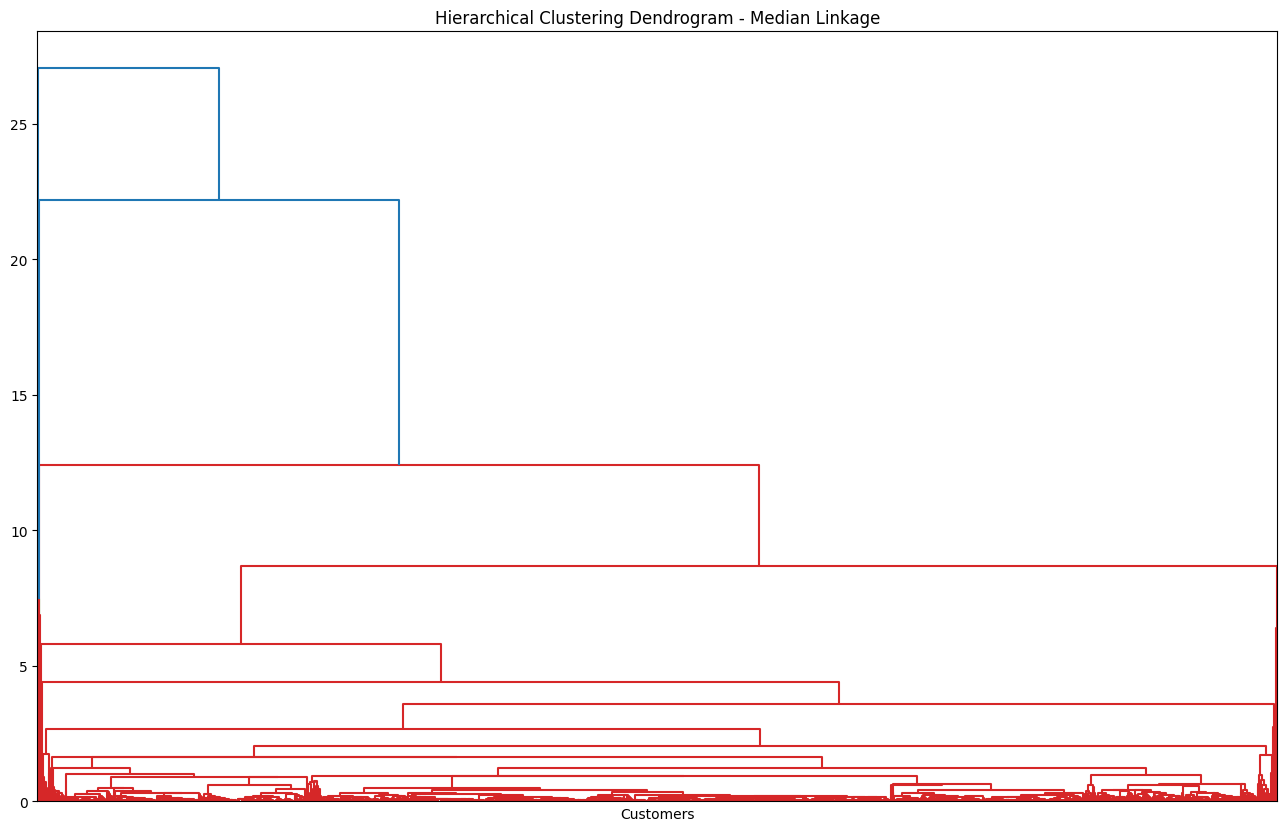

In [70]:
# Plot linkage: median
hc_median = hierarchy.linkage(X_scaled, method= 'median')

plt.figure(figsize= (16, 10))
hierarchy.dendrogram(hc_median)
plt.title('Hierarchical Clustering Dendrogram - Median Linkage')
plt.xlabel('Customers')
plt.ylabel('')
plt.xticks([])
plt.show()


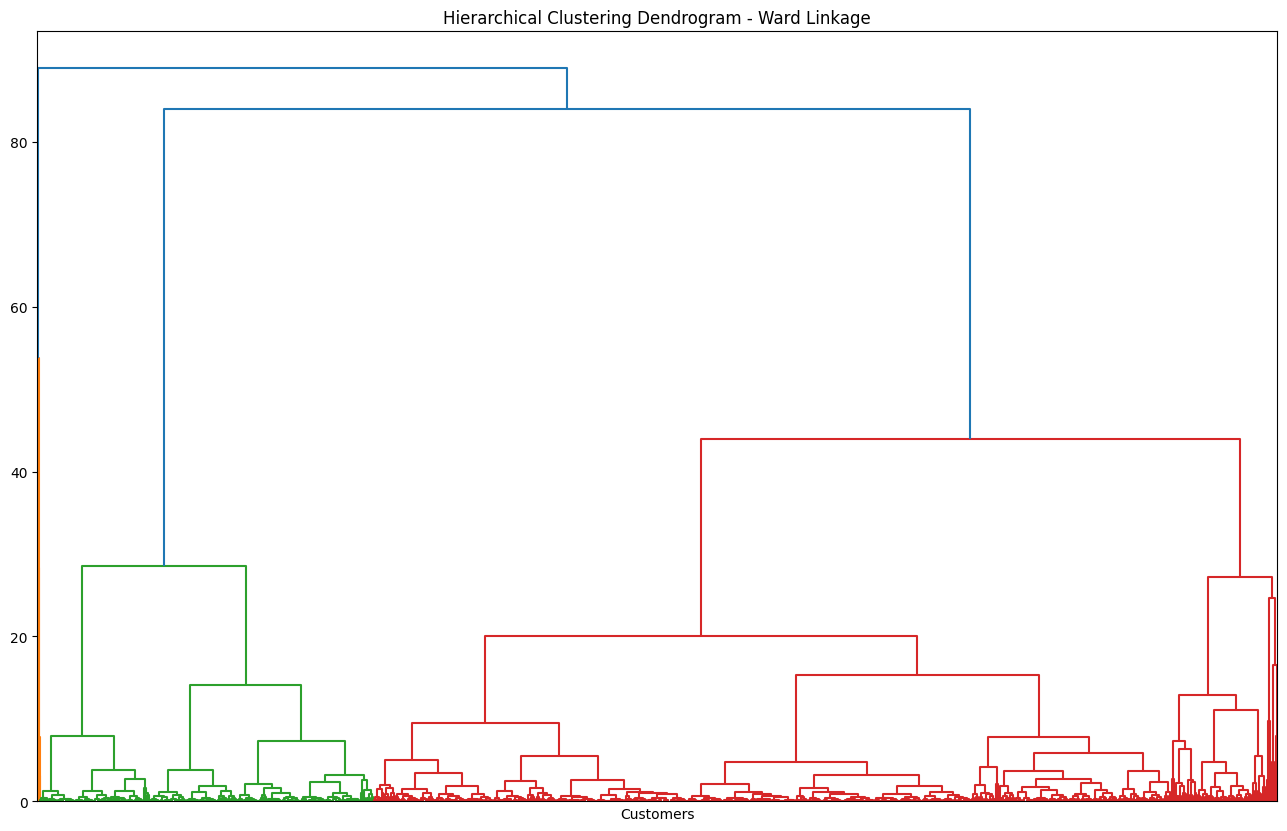

In [71]:
# Plot linkage: ward
hc_ward = hierarchy.linkage(X_scaled, method= 'ward')

plt.figure(figsize= (16, 10))
hierarchy.dendrogram(hc_ward)
plt.title('Hierarchical Clustering Dendrogram - Ward Linkage')
plt.xlabel('Customers')
plt.ylabel('')
plt.xticks([])
plt.show()


Of all linkages, ward linkage seems to produce a clearer result, thus ward linkage would be chosen for modelling.
Now let's find the number of clusters for the hierarchical clustering model with the same process as the K-Means clustering model.

In [72]:
hc_silhouette_scores = []
k_range_hc = range(2, 11)

# Find the silhouette scores
for i in k_range:
    hc = AgglomerativeClustering(n_clusters= i, linkage= 'ward')
    hc.fit(X_scaled)
    score = silhouette_score(X_scaled, hc.labels_)
    hc_silhouette_scores.append(score)


In [73]:
# Take a look at the numbers of clusters and their respective silhouette score
k_dict_hc = {'Number of Clusters': list(k_range_hc), 'Silhouette Score': hc_silhouette_scores}
clusters_hc = pd.DataFrame(k_dict_hc)
clusters_hc

,Number of Clusters,Silhouette Score
0,2,0.939038
1,3,0.586493
2,4,0.587227
3,5,0.578058
4,6,0.533827
5,7,0.534065
6,8,0.522737
7,9,0.525976
8,10,0.355470


Likewise, the result of silhouette scores is somewhat similar to the K-Means clustering. This time, we only check k = 5 or 6.
* k = 5 demonstates the better score.
* k = 6 performs better in the K-Means model.

In [74]:
# Define a function visualising the clusters
def check_hc(data, i):
    kmeans = AgglomerativeClustering(n_clusters= i, linkage= 'ward')
    hc_result = kmeans.fit_predict(data)

    fig = plt.figure(figsize= (15, 15))
    ax = fig.add_subplot(111, projection= '3d')

    labels = [j+1 for j in range(0,i)]

    for j in range(i):
        ax.scatter(X_scaled[hc_result == j, 0], X_scaled[hc_result == j, 1], X_scaled[hc_result == j, 2], label= labels[j])
    
    ax.set_title(f'Customer Segmentation: Hierarchical {i} Clusters')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    plt.legend()

    plt.show()

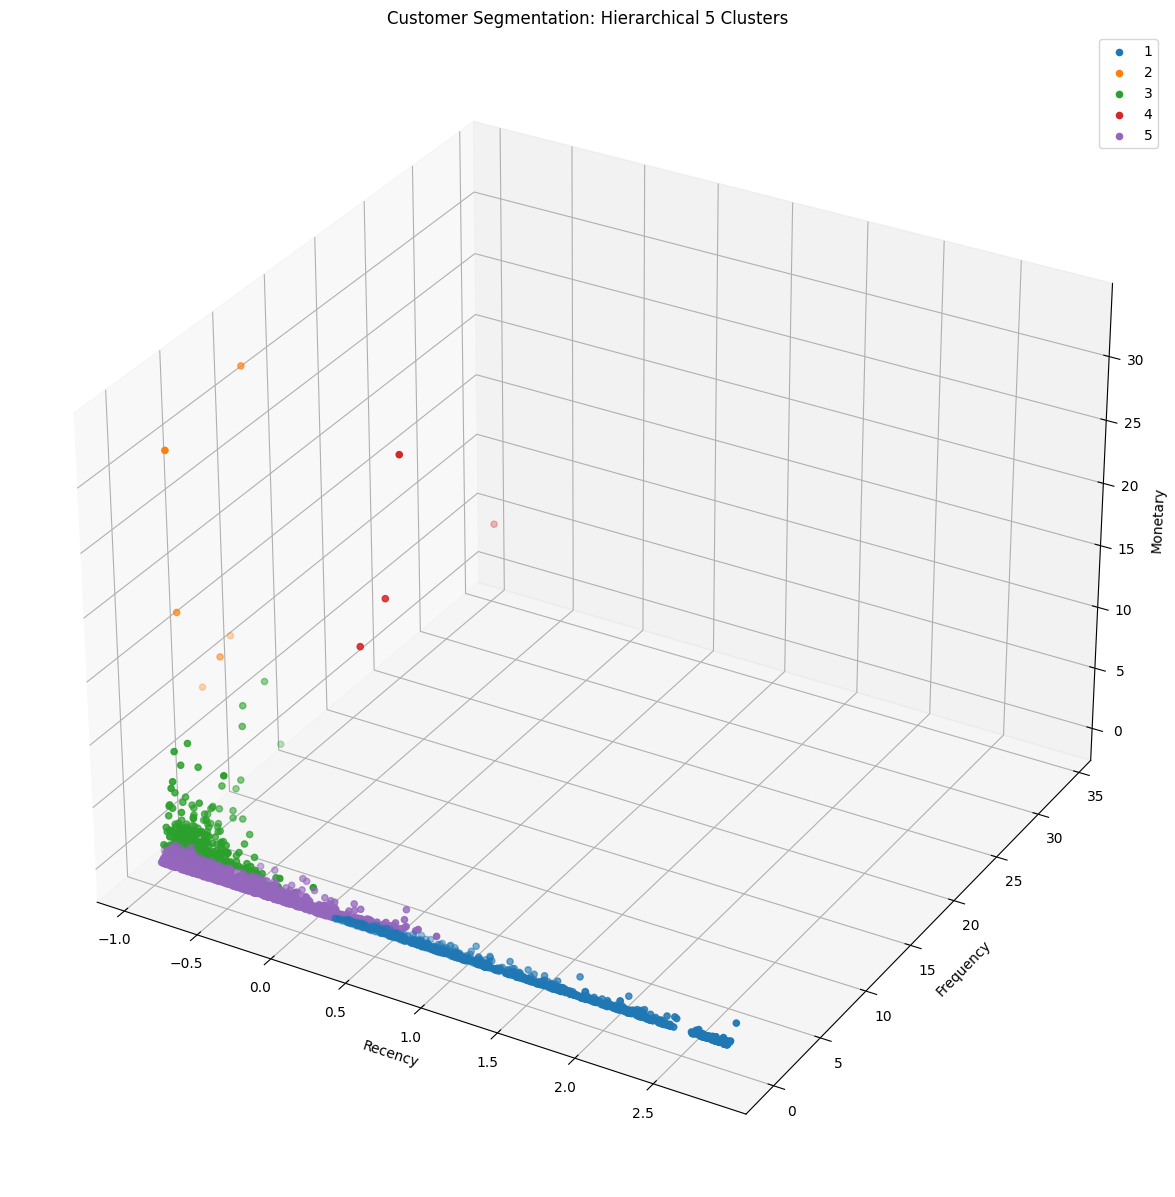

In [75]:
check_hc(X_scaled, 5)

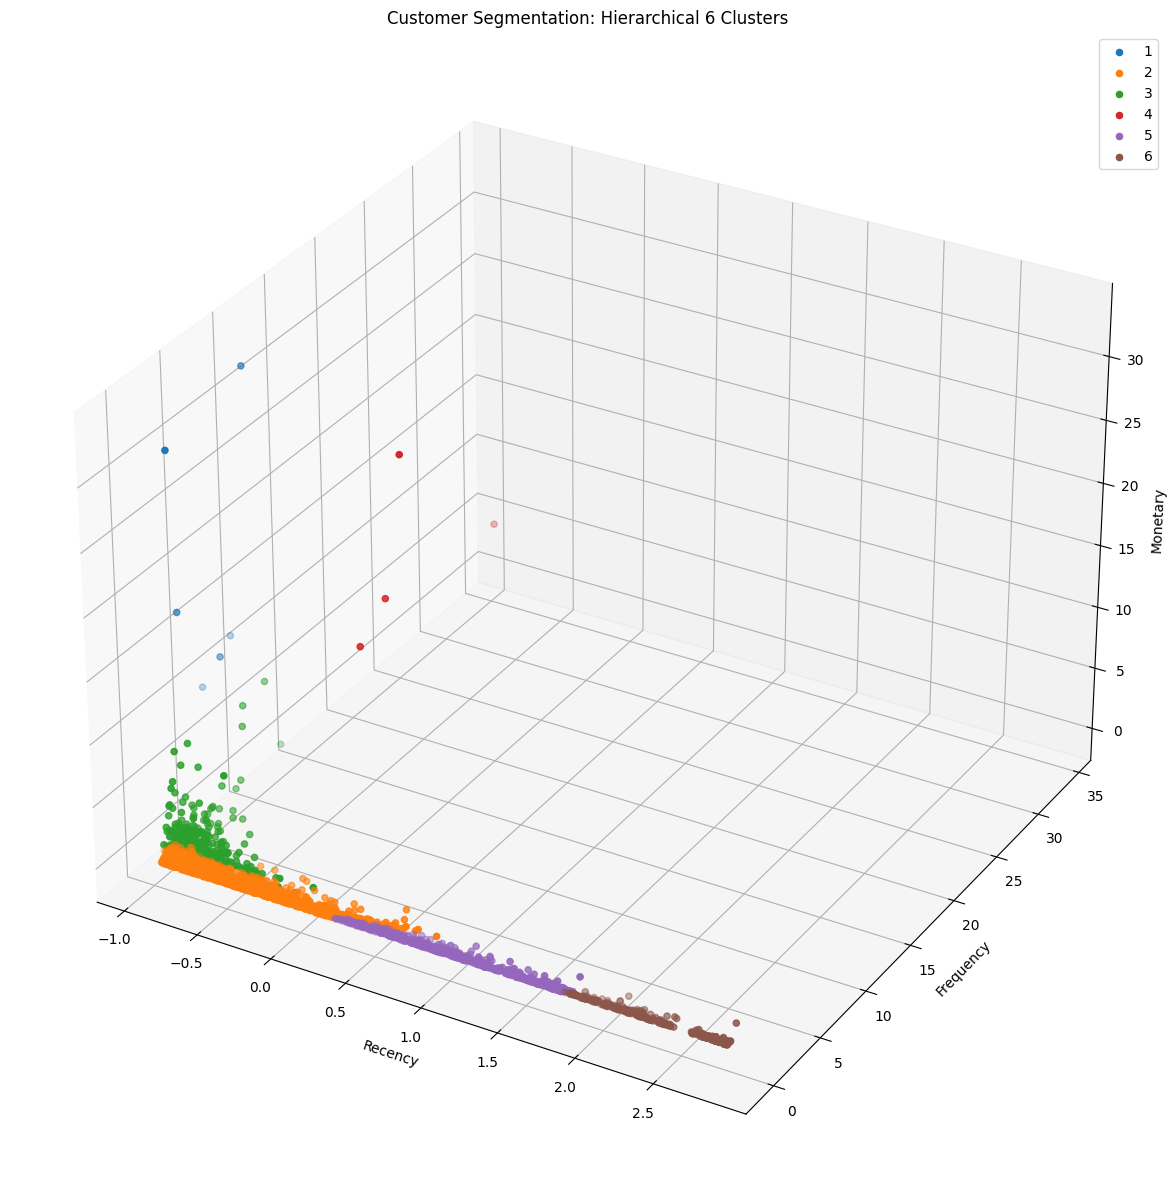

In [76]:
check_hc(X_scaled, 6)

Again, k = 6 is the more suitable number of clusters, due to better clustering at customer recency. In addition, hierarchical clustering with 6 clusters and ward linkage bears a striking resemblance to K-Means clustering with 6 clusters.

In [77]:
hc = AgglomerativeClustering(n_clusters= 6, linkage= 'ward')
hc_cluster = hc.fit_predict(X_scaled)
hc_cluster.reshape(-1,1)
df_rfm_score['Hierarchical Clustering'] = hc_cluster
df_rfm_score.head(10)

,CustomerID,Recency,Frequency,Monetary,K-means Clustering,Hierarchical Clustering
0,12347.0,2,182,4310.00,0,1
1,12348.0,75,27,1437.24,0,1
2,12349.0,19,72,1457.55,0,1
3,12350.0,310,16,294.40,1,5
4,12352.0,36,77,1385.74,0,1
5,12353.0,204,4,89.00,1,4
6,12354.0,232,58,1079.40,1,4
7,12355.0,214,13,459.40,1,4
8,12356.0,23,58,2487.43,0,1
9,12357.0,33,131,6207.67,0,1


## 5.3. Models comparison

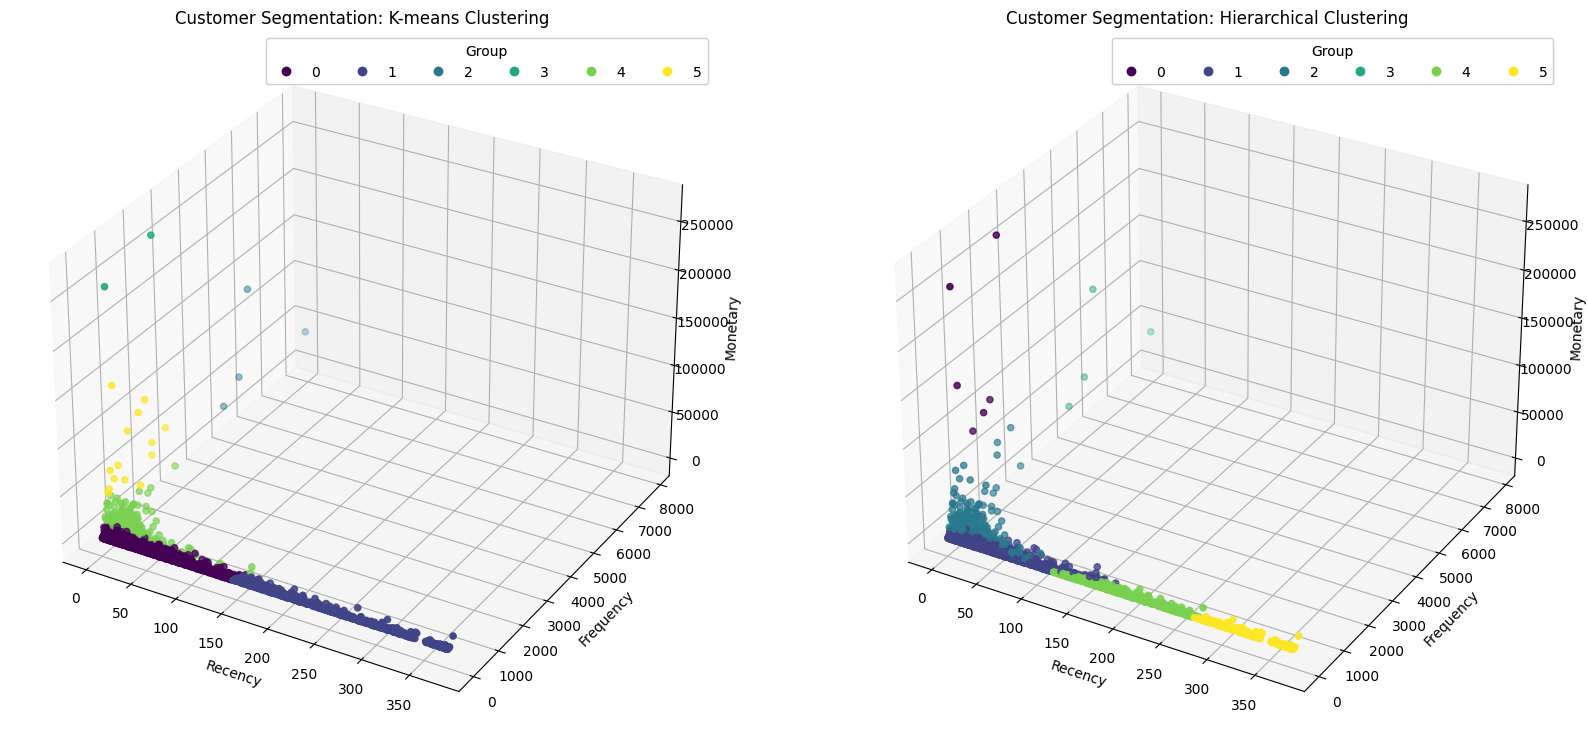

In [78]:
fig = plt.figure(figsize= (20, 20))
ax1 = fig.add_subplot(121, projection= '3d')
ax2 = fig.add_subplot(122, projection= '3d')

scatter1 = ax1.scatter(df_rfm_score['Recency'], df_rfm_score['Frequency'],
            df_rfm_score['Monetary'], c= df_rfm_score['K-means Clustering']) 
ax1.set_title('Customer Segmentation: K-means Clustering')
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary')


scatter2 = ax2.scatter(df_rfm_score['Recency'], df_rfm_score['Frequency'],
            df_rfm_score['Monetary'], c= df_rfm_score['Hierarchical Clustering']) 
ax2.set_title('Customer Segmentation: Hierarchical Clustering')
ax2.set_xlabel('Recency')
ax2.set_ylabel('Frequency')
ax2.set_zlabel('Monetary')

# Add color label legend
legend1 = ax1.legend(*scatter1.legend_elements(),
                     loc= 'upper right', title= 'Group', ncol=6)
legend2 = ax2.legend(*scatter2.legend_elements(),
                     loc= 'upper right', title= 'Group', ncol=6)
ax1.add_artist(legend1)
ax2.add_artist(legend2)

plt.show()

In [79]:
df_rfm_score['K-means Clustering'].value_counts()

0    2900
1    1061
4     345
5      14
2       4
3       2
Name: K-means Clustering, dtype: int64

In [80]:
df_rfm_score['Hierarchical Clustering'].value_counts()

1    2783
4     782
5     383
2     368
0       6
3       4
Name: Hierarchical Clustering, dtype: int64

In [81]:
df_rfm_score.to_csv('RFM Scores & Groups.csv', index= False)

In [82]:
df_rfm_score.groupby('K-means Clustering').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'})

,Recency,Frequency,Monetary
K-means Clustering,,,
0,45.114483,65.243793,1212.316303
1,249.146089,27.915174,486.479717
2,2.000000,5775.500000,65704.797500
3,1.500000,1240.500000,259166.580000
4,15.924638,406.657971,6953.155623
5,9.500000,819.214286,75253.301429


In [83]:
df_rfm_score.groupby('Hierarchical Clustering').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'})

,Recency,Frequency,Monetary
Hierarchical Clustering,,,
0,8.000000,977.333333,167057.075000
1,41.991017,68.305785,1201.694466
2,16.217391,397.807065,8458.210924
3,2.000000,5775.500000,65704.797500
4,197.219949,27.754476,517.810793
5,322.984334,23.540470,361.312063


We can witness some similarities between groups of the 2 models, albeit they're not always 100% the same:
* K-Means 3 ≈ Hierarchical 4
* K-Means 5 ≈ Hierarchical 0
* K-Means 0 ≈ Hierarchical 2
* K-Means 1 = Hierarchical 5
* K-Means 4 = Hierarchical 1
* K-Means 2 = Hierarchical 3

# 6. Final Analysis

## 6.1. Analysis

<font color='green'>Customers</font>
* Domestic buyers (UK buyers) accounted for the majority of the sales, and this would be the store's main type of customer to perform more campaigns.
* From September, there was a burst of new customers, and in November the number of new customers more than tripled that of last year. The reason needs to be found so that the store may replicate this success.

<font color='green'>Sale status</font>
* Most of the sale are from domestic buyers.
* Top products of the time are: White Hanging Heart T-Light Holder, Jumbo Bag Red Retrospot, and Regency Cakestand 3 Tier.
* Towards the end of the year, as a lot of new customers came to the store, the number of order also witness an upturn.
* Although a transaction usually had a moderate amount of quantity, the revenue order was only less than 25 GBP per order, which is not very high.

## 6.2. Models & Customer Groups

Based on the means of 3 features: Recency, Frequency, Monetary, as well as the group of K-Means and Hierarchical Clustering, the customers can be devided into 6 group:

<font color='green'>Group 1: Champion</font>
* K-Means Cluster 4 and Hierarchical Cluster 1
* Very low Recency, high Frequency, and very high Monetary value
* This group is easily the the most profitable group.

<font color='green'>Group 2: Loyal</font>
* K-Means Cluster 2 and Hierarchical Cluster 3
* Very low Recency, very high Frequency, and high Monetary value
* These customers buy the most with a large figure of Frequency.


<font color='green'>Group 3: Potential</font>
* K-Means Cluster 0 and Hierarchical Cluster 2 (*)
* Low Recency, moderate Frequency, and moderate Monetary value
* This type of customer is promising. With a bit of encouragement via marketing campaign to attract them more, they could generate more profit for the store.

<font color='green'>Group 4: Standard</font>
* K-Means Cluster 3 and Hierarchical Cluster 4 (*)
* Moderate Recency, moderate Frequency, and moderate Monetary value
* These buyers take up the largest proportion of all customers, with moderate numbers in all features. They make up the dominant behaviour of customers of this store.

<font color='green'>Group 5: At Risk</font>
* K-Means Cluster 5 and Hierarchical Cluster 0 (*)
* High Recency, low Frequency, and low Monetary value
* This group of customers has not made any purchase in recent time, while making low purchases. Their value to the store is low and they need some attention.

<font color='green'>Group 6: Dormant</font>
* K-Means Cluster 1 and Hierarchical Cluster 5
* Very high Recency, very low Frequency, and very low Monetary value
* There are those who have yet to make any purchase lately, but also did not make many purchases and spent little money. It seems to be unlikely that they will make any purchase from the store again.

(*) Slight difference between the grouping of 2 models